## Imports

In [1]:
import operator
import numpy as np
import pickle as pkl
import random
from numpy import linalg as LA
from matplotlib import pyplot as plt
from sklearn import neighbors
from sklearn.linear_model import LogisticRegression
from time import time
from multiprocessing import Pool

import sys
import copy
import numpy as np
import pandas as pd
import os
import xarray as xr
from operator import itemgetter

from matplotlib import pyplot as plt
import matplotlib as mpl

## Define helper methods

In [6]:
# centralize buckets around test point to avoid bad results caused by test point near bucket edges
def centralize_buckets_around_test_point(bucket_size, base_bucket_edges, verbose, test_point_label):
    bucket_of_sample = np.digitize(test_point_label, base_bucket_edges).item()

    left_edge, right_edge = base_bucket_edges[bucket_of_sample-1], base_bucket_edges[bucket_of_sample]
    
    distance_left_edge, distance_right_edge = np.abs(left_edge - test_point_label), np.abs(right_edge - test_point_label)

    if distance_left_edge == distance_right_edge:
        return base_bucket_edges
    elif distance_left_edge > distance_right_edge:
        # point is closer on right side, shift bucked edges shift right
        distance_to_shift = bucket_size/2 - distance_right_edge
        bucket_edges_shifted = base_bucket_edges + distance_to_shift
    else:
        # point is closer on left side, shift bucked edges shift left
        distance_to_shift = bucket_size/2 - distance_left_edge
        bucket_edges_shifted = base_bucket_edges - distance_to_shift
        
    left_edge_shifted, right_edge_shifted = bucket_edges_shifted[bucket_of_sample-1], bucket_edges_shifted[bucket_of_sample]
    
    distance_left_edge_shifted, distance_right_edge_shifted = left_edge_shifted - test_point_label, right_edge_shifted - test_point_label
    
    difference_between_left_right_shifted_distance = np.round(np.float(np.abs(distance_left_edge_shifted) - np.abs(distance_right_edge_shifted)), 3)
    if difference_between_left_right_shifted_distance != 0:
        raise Exception('Distance was not equal after shift! [%s]' % difference_between_left_right_shifted_distance)

    if verbose:
        print("Bucket of samples:", bucket_of_sample)
        print("Label:", test_point_label)
        print("Edges:", left_edge, right_edge)
        print("Distance edges:", distance_left_edge, distance_right_edge)
        print("Distance to shift", distance_to_shift)
        print("Shifted edges:", left_edge_shifted, right_edge_shifted)
        print("Distance to shifted edges:", distance_left_edge_shifted, distance_right_edge_shifted)
        print("Difference between left & right side: %.3f" % difference_between_left_right_shifted_distance)
        print()
        
    return bucket_edges_shifted
        
month_dict={0:'Jan', 1:'Feb', 2:'Mar', 3:'Apr', 4:'May', 5:'Jun', 6:'Jul', 7:'Aug', 8:'Sept', 9:'Okt', 10:'Nov', 11:'Dec'}

station_idx_mapping = {}
for s_idx, s in enumerate(stations.data):
    station_idx_mapping[s] = s_idx
    
def plotTestIdxResultsWithWeightedInfluences(test_idx, influences):
    # get init, station, rlat, rlon, height and height difference for test idx
    test_init, test_station = test_data_set.iloc[test_idx].as_matrix()[0:2]
    test_station_rlat, test_station_rlon, test_station_height = station_positions.sel(station = test_station).data
    test_station_hh_diff = station_heigh_diff.sel(station = test_station).data
    
    # index in array representation of stations
    test_station_idx = stations.data.tolist().index(test_station)
    # get formatted station name
    test_station_name = station_names[test_station_idx].item()
    
    # define number of influences to be plotted
    k_largest_influences = 200
    k_smallest_influences = 200

    # get largest and smallest influences
    largest_influence_idx = np.argsort(influences)[-k_largest_influences:]
    smallest_influence_idx = np.argsort(influences)[:k_smallest_influences]

    # get array of ('Station','Init') ordered by training sample indices
    init_station_train_data = train_data_set.loc[:,'Init':'Station'].as_matrix()
    
    # get station & init samples with the largest influence
    station_init_by_largest_influence = []
    for train_sample_idx in largest_influence_idx:
        init, station = init_station_train_data[train_sample_idx]
        station_rlat, station_rlon, station_height = station_positions.isel(station = station_idx_mapping[station]).data
        station_hh_diff = station_heigh_diff.isel(station = station_idx_mapping[station]).data.item()
        station_init_by_largest_influence += [(station, init, influences[train_sample_idx], station_rlat, station_rlon, station_height, int(200*station_hh_diff))]
    station_init_by_largest_influence = sorted(station_init_by_largest_influence, key=itemgetter(2))
    largest_influence_data = np.array(list(zip(*station_init_by_largest_influence)), dtype='float64')

    # get station & init samples with the smallest influence
    station_init_by_smallest_influence = []
    for train_sample_idx in smallest_influence_idx:
        init, station = init_station_train_data[train_sample_idx]
        station_rlat, station_rlon, station_height = station_positions.isel(station = station_idx_mapping[station]).data
        station_hh_diff = station_heigh_diff.isel(station = station_idx_mapping[station]).data.item()
        station_init_by_smallest_influence += [(station, init, influences[train_sample_idx], station_rlat, station_rlon, station_height, int(200*station_hh_diff))]
    station_init_by_smallest_influence = sorted(station_init_by_smallest_influence, key=itemgetter(2))
    smallest_influence_data = np.array(list(zip(*station_init_by_smallest_influence)), dtype='float64')

    # plot influence by station
    fig, axes = plt.subplots(2,1, sharex=True, sharey=True, figsize=(16,9))
    
    # sum influence of most influential points per station
    sum_largest_influences_per_station = np.bincount(largest_influence_data[0].astype(int),largest_influence_data[2],
                                                     np.max(stations.data)+1)[stations]
    sum_smallest_influences_per_station = np.bincount(smallest_influence_data[0].astype(int),smallest_influence_data[2],
                                                      np.max(stations.data)+1)[stations]
    
    # plot stations with largest effect
    cax = axes[0].scatter(station_positions.sel(positinal_attribute = 'rlon'),
                 station_positions.sel(positinal_attribute = 'rlat'),
                 c=sum_largest_influences_per_station, s=200, cmap='RdBu',
                 norm=mpl.colors.Normalize(vmin=-np.max(sum_largest_influences_per_station),
                                           vmax=np.max(sum_largest_influences_per_station)))
    axes[0].plot(test_station_rlon, test_station_rlat, marker='o', color='green', markersize=8)
    fig.colorbar(cax, ax=axes[0])
    axes[0].set_title('Highest %s Influences' % k_largest_influences)

    # plot stations with smallest effect
    cax = axes[1].scatter(station_positions.sel(positinal_attribute = 'rlon'),
                 station_positions.sel(positinal_attribute = 'rlat'),
                 c=sum_smallest_influences_per_station, s=200, cmap='RdBu',
                 norm=mpl.colors.Normalize(vmin=-np.max(sum_smallest_influences_per_station),
                                           vmax=np.max(sum_smallest_influences_per_station)))
    axes[1].plot(test_station_rlon, test_station_rlat, marker='o', color='green', markersize=8)
    fig.colorbar(cax, ax=axes[1])
    axes[1].set_title('Smallest %s Influences' % k_smallest_influences)

    plt.suptitle('Influences per Station for Test Station %s (%s) on %s' % (test_station_name,
                                                                         test_station, test_init))
    plt.show()
    plt.close()

    # plot influence by hour
    fig, axes = plt.subplots(2,1, sharex=True, figsize=(16,9))
    
    # sum influence of most influential points per hour
    sum_largest_influences_per_hour = np.bincount([(int(str(m)[6:8]) + 1) % 24 for m in largest_influence_data[1]],
                                                  largest_influence_data[2], 24)
    sum_smallest_influences_per_hour = np.bincount([(int(str(m)[6:8]) + 1) % 24 for m in smallest_influence_data[1]],
                                                    smallest_influence_data[2], 24)
    
    max_absolute_influence = np.maximum(np.max(np.absolute(sum_largest_influences_per_hour)),
                                        np.max(np.absolute(sum_smallest_influences_per_hour)))
    
    # plot stations with largest effect
    axes[0].bar(np.arange(0,24), sum_largest_influences_per_hour, color='blue')
    axes[0].axvline(x=int(test_init[6:8])+1, color='green')
    axes[0].set_ylim(0, max_absolute_influence)
    axes[0].set_title('Highest %s Influences' % k_largest_influences)
    
    # plot stations with largest effect
    axes[1].bar(np.arange(0,24), sum_smallest_influences_per_hour, color='red')
    axes[1].axvline(x=int(test_init[6:8])+1,color='green')
    axes[1].set_xlim(-1,24,1)
    axes[1].set_ylim(-max_absolute_influence, 0)
    axes[1].set_title('Smallest %s Influences' % k_smallest_influences)
    plt.suptitle('Influences per Hour for Test Station %s (%s) on %s' % (test_station_name,
                                                                         test_station, test_init))
    plt.setp(axes, xticks=range(24), xticklabels=["%02d:00" % h for h in range(24)])
    plt.show()
    plt.close()

    # plot influence by month
    fig, axes = plt.subplots(2,1, sharex=True, figsize=(16,9))
    
    # sum influence of most influential points per month
    sum_largest_influences_per_month = np.bincount([int(str(m)[2:4]) for m in largest_influence_data[1]],
                                                  largest_influence_data[2], 13)[1:]
    sum_smallest_influences_per_month = np.bincount([int(str(m)[2:4]) for m in smallest_influence_data[1]],
                                                    smallest_influence_data[2], 13)[1:]
    
    max_absolute_influence = np.maximum(np.max(np.absolute(sum_largest_influences_per_month)),
                                        np.max(np.absolute(sum_smallest_influences_per_month)))
        
    # plot stations with largest effect
    axes[0].bar(np.arange(1,13), sum_largest_influences_per_month, color='blue')
    axes[0].axvline(x=int(test_init[2:4]),color='green')
    axes[0].set_ylim(0, max_absolute_influence)
    axes[0].set_title('Highest %s Influences' % k_largest_influences)

    # plot stations with smallest effect
    axes[1].bar(np.arange(1,13), sum_smallest_influences_per_month, color='red')
    axes[1].axvline(x=int(test_init[2:4]),color='green')
    axes[1].set_xlim(0,13,1)
    axes[1].set_ylim(-max_absolute_influence, 0)
    axes[1].set_title('Smallest %s Influences' % k_smallest_influences)
    plt.suptitle('Influences per Month for Test Station %s (%s) on %s' % (test_station_name,
                                                                         test_station, test_init))
    plt.setp(axes[1], xticks=np.arange(1,13), xticklabels=[month_dict[m] for m in range(12)])
    plt.show()
    plt.close()
    
    
    # plot influence by year
    fig, axes = plt.subplots(2,1, sharex=True, figsize=(16,9))
    
    # sum influence of most influential points per year
    sum_largest_influences_per_year = np.take(np.bincount([int(str(m)[:2]) for m in largest_influence_data[1]],
                                                  largest_influence_data[2], 19), (15,16,17,18))
    sum_smallest_influences_per_year = np.take(np.bincount([int(str(m)[:2]) for m in smallest_influence_data[1]],
                                                    smallest_influence_data[2], 19), (15,16,17,18))
    
    max_absolute_influence = np.maximum(np.max(np.absolute(sum_largest_influences_per_year)),
                                        np.max(np.absolute(sum_smallest_influences_per_year)))
    
    # plot stations with largest effect
    axes[0].bar(np.arange(15,19), sum_largest_influences_per_year, color='blue')
    axes[0].axvline(x=int(test_init[:2]),color='green')
    axes[0].set_ylim(0, max_absolute_influence)
    axes[0].set_title('Highest %s Influences' % k_largest_influences)

    # plot stations with smallest effect
    axes[1].bar(np.arange(15,19), sum_smallest_influences_per_year, color='red')
    axes[1].axvline(x=int(test_init[:2]),color='green')
    axes[1].set_xlim(14,19,1)
    axes[1].set_ylim(-max_absolute_influence, 0)
    axes[1].set_title('Smallest %s Influences' % k_smallest_influences)
    plt.suptitle('Influences per Year for Test Station %s (%s) on %s' % (test_station_name,
                                                                         test_station, test_init))
    plt.setp(axes[1], xticks=np.arange(15,19), xticklabels=['2015', '2016', '2017', '2018'])
    plt.show()
    plt.close()
    
    # plot influence against height
    fig, axes = plt.subplots(2,1, sharex=True, figsize=(16,9))
    
    # sum influence of most influential points per height
    sum_largest_influences_per_height = np.bincount(largest_influence_data[5].astype(int), largest_influence_data[2])
    sum_smallest_influences_per_height = np.bincount(smallest_influence_data[5].astype(int), smallest_influence_data[2])
    
    max_absolute_influence = np.maximum(np.max(np.absolute(sum_largest_influences_per_height)),
                                        np.max(np.absolute(sum_smallest_influences_per_height)))
    
    # plot stations with largest effect
    axes[0].bar(range(len(sum_largest_influences_per_height)), sum_largest_influences_per_height, color='blue', width=15)
    axes[0].axvline(x=test_station_height,color='green')
    axes[0].set_ylim(0, max_absolute_influence)
    axes[0].set_title('Highest %s Influences' % k_largest_influences)
    
    # plot stations with smallest effect
    axes[1].bar(range(len(sum_smallest_influences_per_height)), sum_smallest_influences_per_height, color='red', width=15)
    axes[1].axvline(x=test_station_height,color='green')
    axes[1].set_ylim(-max_absolute_influence, 0)
    axes[1].set_title('Smallest %s Influences' % k_smallest_influences)
    
    plt.suptitle('Influences per Height for Test Station %s (%s) on %s' % (test_station_name,
                                                                         test_station, test_init))
    plt.show()
    plt.close()

    # plot influence against height difference
    fig, axes = plt.subplots(2,1, sharex=True, figsize=(16,9))
    
    # sum influence of most influential points per height difference
    sum_largest_influences_per_height_difference = np.bincount(largest_influence_data[6].astype(int), largest_influence_data[2])
    sum_smallest_influences_per_height_difference = np.bincount(smallest_influence_data[6].astype(int), smallest_influence_data[2])
    
    max_absolute_influence = np.maximum(np.max(np.absolute(sum_largest_influences_per_height_difference)),
                                        np.max(np.absolute(sum_smallest_influences_per_height_difference)))
    
    # plot stations with largest effect
    axes[0].bar(range(len(sum_largest_influences_per_height_difference)), sum_largest_influences_per_height_difference, color='blue')
    axes[0].axvline(x=int(test_station_hh_diff*200),color='green')
    axes[0].set_ylim(0, max_absolute_influence)
    axes[0].set_title('Highest %s Influences' % k_largest_influences)

    # plot stations with smallest effect
    axes[1].bar(range(len(sum_smallest_influences_per_height_difference)), sum_smallest_influences_per_height_difference, color='red')
    axes[1].axvline(x=int(test_station_hh_diff*200),color='green')
    axes[1].set_ylim(-max_absolute_influence, 0)
    axes[1].set_title('Smallest %s Influences' % k_smallest_influences)
    
    plt.suptitle('Influences per Height Difference for Test Station %s (%s) on %s' % (test_station_name,
                                                                         test_station, test_init))
    plt.show()
    plt.close()

## Load data

In [3]:
with open('/home/ninow/master_thesis/code/project/results/data_valuation/neural_embeddings.pkl','rb') as handle:
    neural_embeddings = pkl.load(handle)
with open('/home/ninow/master_thesis/code/project/results/data_valuation/neural_embeddings_error_prediction.pkl','rb') as handle:
    neural_embeddings_error_prediction = pkl.load(handle)

In [4]:
# load station positions to plot them on map
station_data = pkl.load(open('/mnt/ds3lab-scratch/ninow/preprocessed_data/station/grid_size_1/time_invariant_data_per_station.pkl','rb'))
station_positions = station_data.station_position.sel(positinal_attribute = ['rlat', 'rlon','height_raw'])
stations = station_data.station
station_names = station_data.station_name
# load time invariant grid topo feature data
topo = pkl.load(open('/mnt/ds3lab-scratch/ninow/preprocessed_data/station/grid_size_1/time_invariant_data_per_station.pkl','rb'))
station_heigh_diff = topo.grid_data.sel(feature='HH_DIFF').squeeze()
stations_lat_idx = station_data.closest_grid_point.sel(direction = 'lat_2d_global')
stations_lat_idx = stations_lat_idx - np.min(stations_lat_idx)
stations_lon_idx = station_data.closest_grid_point.sel(direction = 'lon_2d_global')
stations_lon_idx = stations_lon_idx - np.min(stations_lon_idx)

In [5]:
# load prediction error from prediction run
prediction_error = pkl.load(open('/mnt/ds3lab-scratch/ninow/final_results/network/model_predictions/knn_1/FC_L3_1024_256_64_TD_GTI_STI_grid_1_bs_64_tf_0.1_optim_sgd_lr_0.0005_sl_24/model_run_error.pkl', 'rb')).run_0

## Prepare Data

In [7]:
# split data set into train and test
#train_data_set = neural_embeddings['train_embeddings']
#train_label_set = neural_embeddings['train_labels']
#test_data_set = neural_embeddings['test_embeddings']
#test_label_set = neural_embeddings['test_labels']

train_data_set = neural_embeddings_error_prediction['train_embeddings']
train_label_set = neural_embeddings_error_prediction['train_labels']
test_data_set = neural_embeddings_error_prediction['test_embeddings']
test_label_set = neural_embeddings_error_prediction['test_labels']

# get numpy representation of neural embeddings
X_train = train_data_set.as_matrix()[:,2:]
Y_train_temp = train_label_set.as_matrix()[:]
X_test = test_data_set.as_matrix()[:,2:]
Y_test_temp = test_label_set.as_matrix()[:]

# calculate number of training examples
num_train_examples = X_train.shape[0]
num_test_examples = X_test.shape[0]
num_features = X_train.shape[1]

In [8]:
num_test_examples

103210

## Calculate Shapley Values with KNN-Regression

In [31]:
def get_distance(features, vector):
    norms = features.shape[0] * [0]
    for i in range(0, features.shape[0]):
        n = LA.norm(features[i] - vector)
        assert(n is not None)
        norms[i] = n
    return norms

def get_values(distances, test_idx, Y_train_shifted, Y_test_shifted):
    values = np.zeros(num_train_examples)
    i = len(distances)
    lastvalue = 0
    lastkey = -1
    K = 50
    for key in np.argsort(distances)[::-1]:
        if i == len(distances):
            lastvalue = 0
        else:
            # print(Y_train[key] == Y_test[test_idx], Y_train[lastkey] == Y_test[test_idx], Y_train[key], Y_test[test_idx], Y_train[lastkey], Y_test[test_idx])
            value = 1.0 * (1.0 * (Y_train_shifted[key] == Y_test_shifted[test_idx]) - 1.0 * (Y_train_shifted[lastkey] == Y_test_shifted[test_idx])) \
                                            / K * (min(K-1, i-1) + 1) / i
            lastvalue = lastvalue + value
        lastkey = key
        i = i - 1

        values[key] = lastvalue
    return values

def run_knn(test_indices, Y_train, Y_test, cetralize_function):
    n_test_samples = len(test_indices)
    for idx, i in enumerate(test_indices):
        start = time()
        
        # adapt the bins to be centralized around thest point
        bucket_edges_shifted = cetralize_function(Y_test[i])
    
        # get index of bucket for each training data
        Y_train_shifted = np.digitize(Y_train, bucket_edges_shifted) - 1
        Y_test_shifted = np.digitize(Y_test, bucket_edges_shifted) - 1
        
        distances = get_distance(X_train, X_test[i]) # get distance to test image
        knn_value = get_values(distances, i, Y_train_shifted, Y_test_shifted)
        
        try:
            knn_values += knn_value
        except:
            knn_values = knn_value
        
        if (i+1) % 50 == 0:
            print('Calculation of knn values for test idx=%s took %s [%.2f%%]' % (i, time() - start, (idx/len(test_indices))*100))
    return knn_values

def get_knn_shapley_values(Y_train, Y_test, test_indices, bucket_size=None):
# adapt the labels to classes
    min_label, max_label = np.minimum(np.min(Y_train_temp),np.min(Y_test_temp)), np.maximum(np.max(Y_train_temp),np.max(Y_test_temp))
    # use the same amount of classes as in the temperature prediction experiment
    n_classes = 33

    # the size of each bucket
    size_of_bucket = (max_label - min_label)/n_classes

    # we add two buckets that all sampels stay in the range on the left or right side, even if we shift the edges
    bucket_edges = np.linspace(min_label-size_of_bucket,max_label+size_of_bucket,n_classes+3)

    cetralize_function = lambda y: centralize_buckets_around_test_point(size_of_bucket, bucket_edges, False, y)

    return (test_indices, run_knn(test_indices, Y_train, Y_test, cetralize_function))

## Calculate Shapley Values with KNN with Temp. prediction data

### Select randomly 20% of test data

In [19]:
knn_shapley_values = np.load('/mnt/ds3lab-scratch/ninow/final_results/data_valuation/influences_final/knn_results_20_percent_bucket_0_5_k_50.npz')['arr_0']
test_point_selection = []
for result in knn_shapley_values:
    test_point_selection += result[0]

In [20]:
parallel_chunks = np.array_split(test_point_selection,16)

### Calculate shapley values in parallel using KNN approach

In [32]:
shapley_results = []
with Pool(processes=16) as pool:
    process_results = []
    for chunk_idx, chunk in enumerate(parallel_chunks):
        process_results.append(pool.apply_async(get_knn_shapley_values, (Y_train_temp, Y_test_temp, list(chunk))))
        
            # aggregate results from all processes
    for ps_idx, ps_result in enumerate(process_results):
        # sync processes
        x = ps_result.get()
        shapley_results += [x]
        print('[Process %s] Synchronized after calculating shapley values.' % ps_idx)

Calculation of knn values for test idx=12799 took 36.27978277206421 [0.00%]
Calculation of knn values for test idx=37999 took 36.91769480705261 [0.08%]
Calculation of knn values for test idx=70699 took 37.08477973937988 [0.39%]
Calculation of knn values for test idx=38049 took 36.707298278808594 [0.70%]
Calculation of knn values for test idx=99 took 36.09672498703003 [1.08%]
Calculation of knn values for test idx=90099 took 34.45350503921509 [1.40%]
Calculation of knn values for test idx=64349 took 36.178658962249756 [1.71%]
Calculation of knn values for test idx=57649 took 36.29725193977356 [1.94%]
Calculation of knn values for test idx=149 took 33.58196425437927 [2.01%]
Calculation of knn values for test idx=50999 took 34.28226637840271 [2.17%]
Calculation of knn values for test idx=70799 took 34.7252938747406 [2.25%]
Calculation of knn values for test idx=25499 took 36.514952421188354 [2.40%]
Calculation of knn values for test idx=199 took 36.5059449672699 [2.40%]
Calculation of knn

Calculation of knn values for test idx=72299 took 35.2853057384491 [25.35%]
Calculation of knn values for test idx=1699 took 33.301846981048584 [25.56%]
Calculation of knn values for test idx=91649 took 33.75170040130615 [25.58%]
Calculation of knn values for test idx=78849 took 33.64738416671753 [26.82%]
Calculation of knn values for test idx=39699 took 33.8664116859436 [26.67%]
Calculation of knn values for test idx=52599 took 33.634238481521606 [26.98%]
Calculation of knn values for test idx=27149 took 33.3474907875061 [27.44%]
Calculation of knn values for test idx=8149 took 35.20591497421265 [27.11%]
Calculation of knn values for test idx=20999 took 33.750723123550415 [27.29%]
Calculation of knn values for test idx=39749 took 33.52504324913025 [27.52%]
Calculation of knn values for test idx=27199 took 33.33843469619751 [27.83%]
Calculation of knn values for test idx=85349 took 36.14078712463379 [28.22%]
Calculation of knn values for test idx=46149 took 35.33368968963623 [28.45%]
C

Calculation of knn values for test idx=86449 took 35.09392762184143 [46.90%]
Calculation of knn values for test idx=2949 took 35.495455741882324 [46.55%]
Calculation of knn values for test idx=9299 took 33.71609902381897 [46.24%]
Calculation of knn values for test idx=41099 took 35.80426239967346 [47.98%]
Calculation of knn values for test idx=67399 took 33.50730037689209 [48.53%]
Calculation of knn values for test idx=3049 took 36.12608599662781 [47.79%]
Calculation of knn values for test idx=41149 took 35.76206612586975 [48.91%]
Calculation of knn values for test idx=86649 took 36.29801917076111 [49.77%]
Calculation of knn values for test idx=22399 took 34.50711965560913 [49.84%]
Calculation of knn values for test idx=15949 took 33.797892570495605 [49.53%]
Calculation of knn values for test idx=47499 took 35.20984387397766 [49.92%]
Calculation of knn values for test idx=67599 took 35.52864098548889 [50.93%]
Calculation of knn values for test idx=80349 took 35.535669565200806 [51.32%]

Calculation of knn values for test idx=81749 took 34.76609754562378 [71.94%]
Calculation of knn values for test idx=101399 took 33.86989641189575 [72.09%]
Calculation of knn values for test idx=17299 took 36.151062965393066 [71.24%]
Calculation of knn values for test idx=23699 took 33.86158323287964 [71.86%]
Calculation of knn values for test idx=94649 took 35.36490225791931 [72.17%]
Calculation of knn values for test idx=75499 took 33.77131986618042 [72.56%]
Calculation of knn values for test idx=101499 took 33.85102844238281 [73.10%]
Calculation of knn values for test idx=49049 took 33.443782806396484 [72.79%]
Calculation of knn values for test idx=55749 took 33.449946641922 [73.18%]
Calculation of knn values for test idx=88199 took 34.836963415145874 [73.26%]
Calculation of knn values for test idx=4699 took 33.52098035812378 [72.42%]
Calculation of knn values for test idx=10999 took 33.700172424316406 [72.50%]
Calculation of knn values for test idx=42749 took 35.97482466697693 [73.7

[Process 1] Synchronized after calculating shapley values.
[Process 2] Synchronized after calculating shapley values.
[Process 3] Synchronized after calculating shapley values.
[Process 4] Synchronized after calculating shapley values.
[Process 5] Synchronized after calculating shapley values.
[Process 6] Synchronized after calculating shapley values.
[Process 7] Synchronized after calculating shapley values.
[Process 8] Synchronized after calculating shapley values.
[Process 9] Synchronized after calculating shapley values.
[Process 10] Synchronized after calculating shapley values.
[Process 11] Synchronized after calculating shapley values.
[Process 12] Synchronized after calculating shapley values.
[Process 13] Synchronized after calculating shapley values.
[Process 14] Synchronized after calculating shapley values.
[Process 15] Synchronized after calculating shapley values.


In [33]:
shapley_results_class_33_error_prediction = shapley_results

In [34]:
np.savez('/mnt/ds3lab-scratch/ninow/final_results/data_valuation/influences_final/knn_results_20_percent_class_33_k_50_error_prediction', shapley_results_class_33_error_prediction)

In [28]:
complete_shapley_sum = None
for result in shapley_results_class_131_error_prediction:
    try:
        complete_shapley_sum += result[1]
    except:
        print('First')
        complete_shapley_sum = result[1]

First


In [29]:
complete_shapley_sum

array([ 0.00288521,  0.00587048,  0.00179653, ...,  0.00807006,
        0.00567224, -0.00300859])

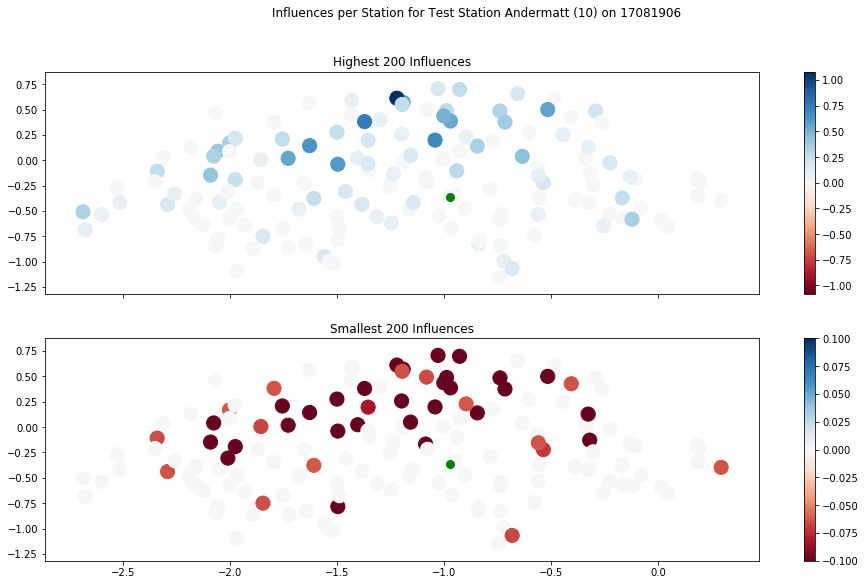

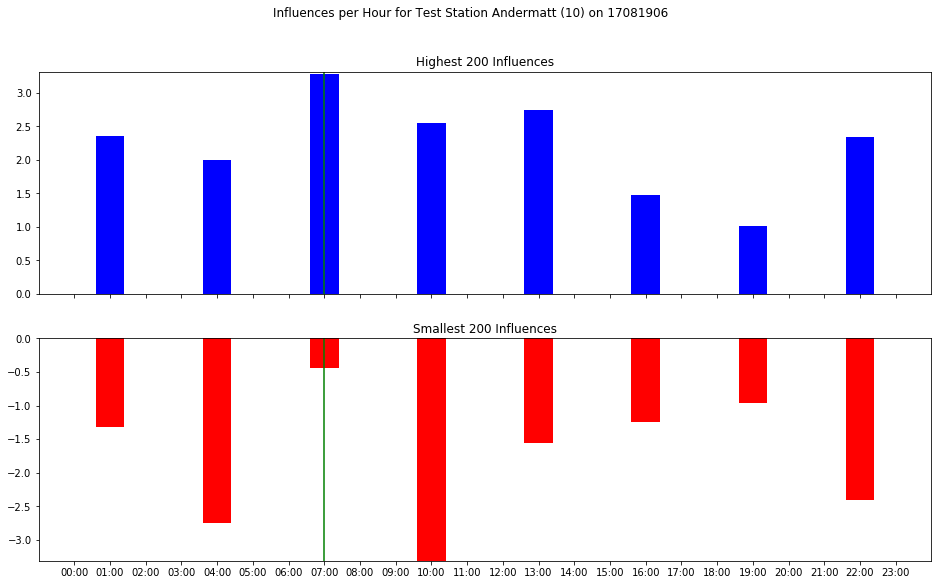

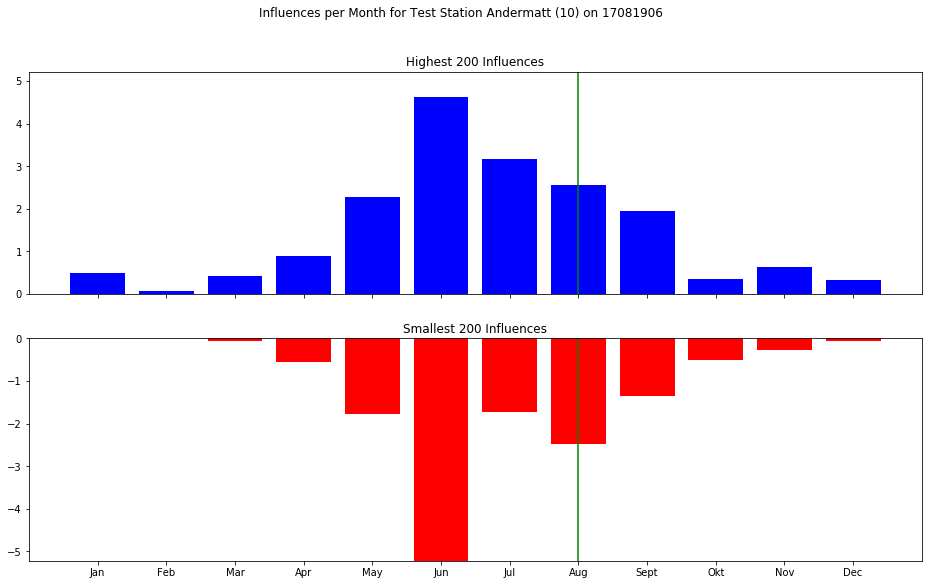

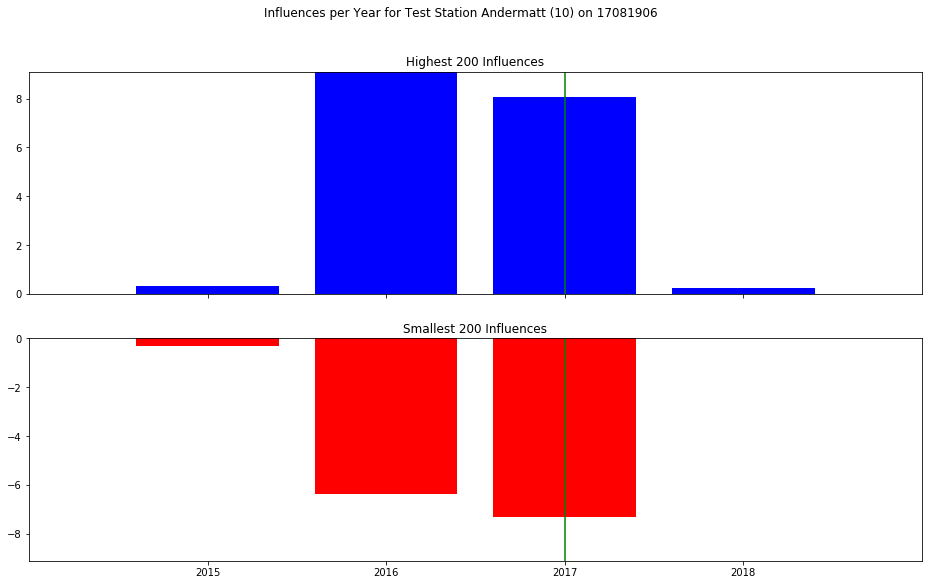

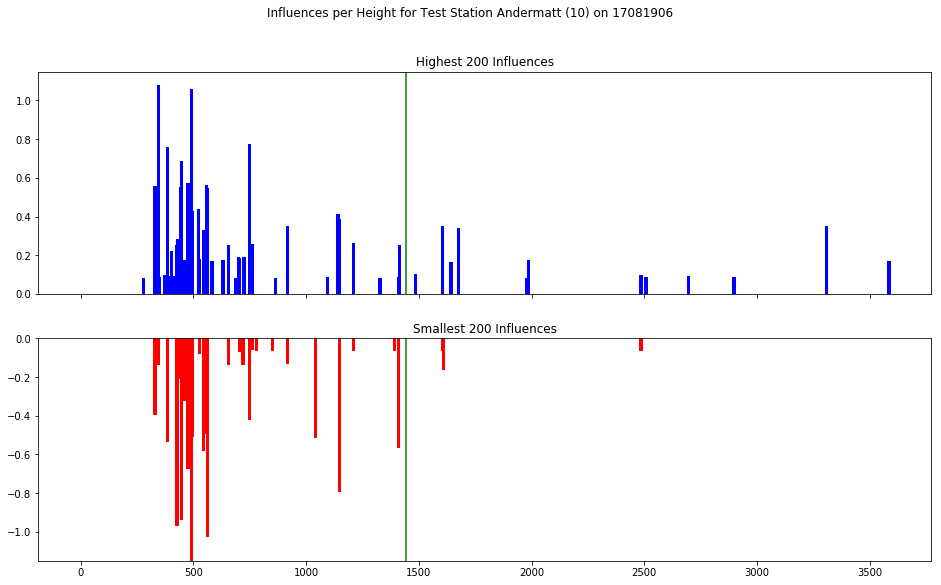

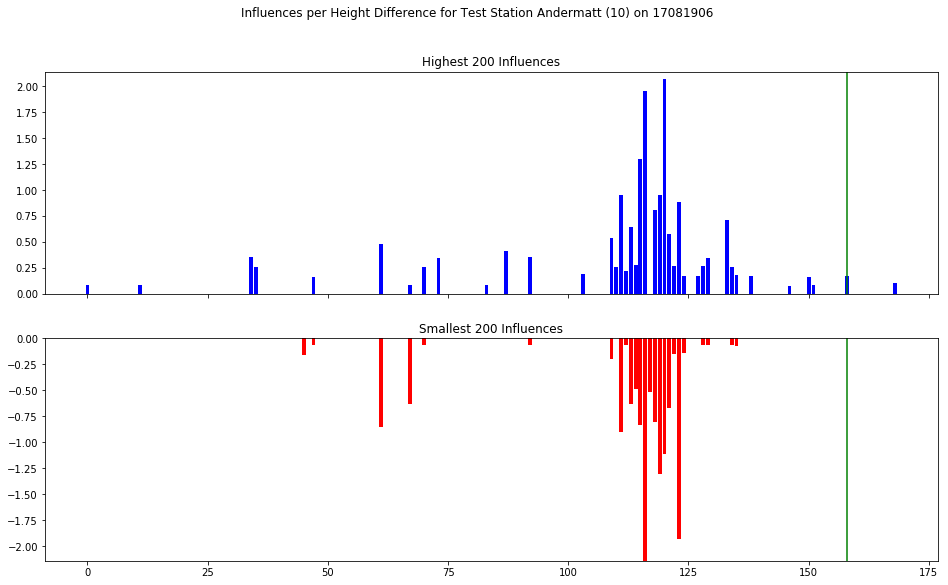

In [30]:
plotTestIdxResultsWithWeightedInfluences(0, complete_shapley_sum)

In [88]:
test_indices = [0, 102277, 51099, 81653, 22249, 23700, 97828, 68426]
actual_loss_diffs = {}
for test_index in test_indices:
    actual_loss_diffs[test_index] = run_knn([test_index], Y_train_temp, Y_test_temp)

Calculation of knn values for test idx=0 took 22.652302503585815
Calculation of knn values for test idx=102277 took 22.727498531341553
Calculation of knn values for test idx=51099 took 22.634960651397705
Calculation of knn values for test idx=81653 took 22.65362286567688
Calculation of knn values for test idx=22249 took 22.525287628173828
Calculation of knn values for test idx=23700 took 22.47892665863037
Calculation of knn values for test idx=97828 took 22.48391819000244
Calculation of knn values for test idx=68426 took 22.164478540420532


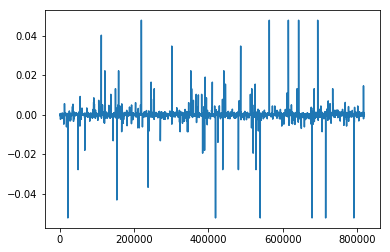

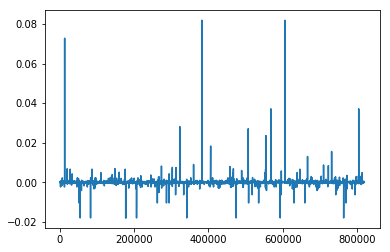

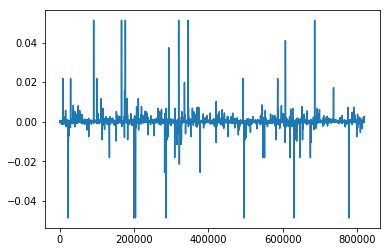

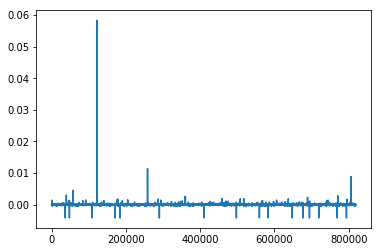

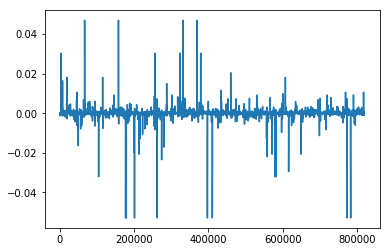

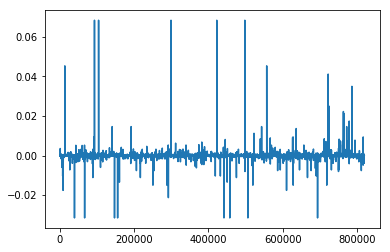

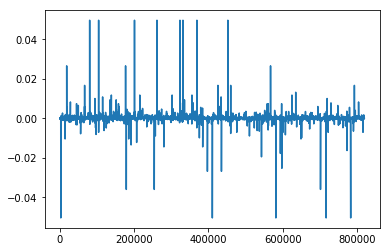

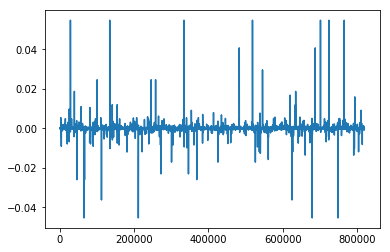

In [89]:
for key, value in actual_loss_diffs.items():
    plt.plot(value)
    plt.show()

In [ ]:
for key, value in actual_loss_diffs.items():
    init, station = test_data_set.iloc[key].as_matrix()[0:2]
    print(np.min(value), np.max(value))
    value = np.array(sorted(value))
    best_loss = np.argsort(value)
    fig = plt.figure(figsize=(16,9))
    
    # plot samples better than 0.005
    plt.plot(value[np.where(value >= 0.005)])
    plt.title('Test samples with Value >= 0.005 (best) for Station %s at Init %s' % (station , init))
    plt.show()
    plt.close()
    
    # plot samples worse thatn -0.005
    fig = plt.figure(figsize=(16,9))
    plt.plot(value[np.where(value <= -0.005)])
    plt.title('Test samples with Value <= -0.005 (worst) for Station %s at Init %s' % (station , init))
    plt.show()
    plt.close()

## Calculate Shapley Vales with different Bucket Sizes For July, 15:00, 2017 Data

In [12]:
july_15_15_00_indices = list(test_data_set.loc[(test_data_set['Init'].str.contains('1707..15'))].index)

In [50]:
test_data_set.loc[july_15_15_00_indices]

,Init,Station,0,1,2,3,4,5,6,7,...,54,55,56,57,58,59,60,61,62,63
31,17070415,18,2.304683,0.0,0.0,0.000000,0.0,2.111537,0.289062,0.000000,...,0.006201,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.490801,0.126547
38,17070415,738,2.277055,0.0,0.0,0.000000,0.0,2.079044,0.339197,0.000000,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.480503,0.061722
124,17070415,152,2.046664,0.0,0.0,0.000000,0.0,1.966487,0.235792,0.000000,...,0.028238,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.460066,0.070140
163,17070615,42,1.692284,0.0,0.0,0.000000,0.0,1.703321,0.276211,0.000000,...,0.001998,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.436527,0.000000
190,17070415,56,1.922184,0.0,0.0,0.000000,0.0,1.788197,0.277695,0.000000,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.434981,0.049765
343,17070515,1024,2.467316,0.0,0.0,0.000000,0.0,2.270184,0.360682,0.000000,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.569151,0.190641
385,17070615,85,2.839386,0.0,0.0,0.000000,0.0,2.638593,0.331174,0.000000,...,0.004941,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.610897,0.163998
492,17070515,139,0.923139,0.0,0.0,0.000000,0.0,0.896026,0.269952,0.000000,...,0.000000,0.0,0.0,0.000000,0.002653,0.0,0.0,0.0,0.307804,0.000000
565,17070615,58,2.745109,0.0,0.0,0.000000,0.0,2.542286,0.347846,0.000000,...,0.017209,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.574799,0.141200
951,17070615,11,2.557558,0.0,0.0,0.000000,0.0,2.360972,0.373030,0.000000,...,0.000000,0.0,0.0,0.078181,0.000000,0.0,0.0,0.0,0.601384,0.193654


In [47]:
july_15_15_00_indices

[31,
 38,
 124,
 163,
 190,
 343,
 385,
 492,
 565,
 951,
 1214,
 1277,
 1324,
 1368,
 1636,
 1781,
 1945,
 2295,
 2411,
 3056,
 3228,
 3523,
 3575,
 3842,
 3977,
 4613,
 4762,
 5807,
 6268,
 6638,
 6931,
 7051,
 7412,
 7643,
 7693,
 7984,
 8226,
 8252,
 8352,
 8819,
 8847,
 8892,
 9904,
 10327,
 10374,
 10375,
 10461,
 10538,
 10805,
 11276,
 11828,
 12084,
 12898,
 14043,
 14090,
 14129,
 14160,
 14601,
 14770,
 14815,
 14826,
 14871,
 15028,
 15239,
 15806,
 15842,
 15922,
 16467,
 16469,
 16489,
 16840,
 16941,
 17009,
 17116,
 17255,
 17751,
 18549,
 18564,
 18595,
 18603,
 18694,
 19317,
 19654,
 19673,
 20452,
 20458,
 20465,
 20722,
 21049,
 21184,
 21187,
 21936,
 22180,
 22278,
 22437,
 22660,
 22772,
 22790,
 22908,
 22994,
 23462,
 23742,
 23753,
 24129,
 24159,
 24198,
 24393,
 24409,
 24518,
 24524,
 25013,
 25088,
 25111,
 25513,
 25858,
 25966,
 25985,
 26133,
 26394,
 26436,
 26530,
 26673,
 26677,
 26701,
 26776,
 26833,
 26855,
 27013,
 27143,
 27717,
 27735,
 28259,

### Calculate shapley values in parallel for different bucket sizes

In [35]:
shapley_results = []
with Pool(processes=6) as pool:
    process_results = []
    for b_size in [0.1, 0.3 ,0.5, 1, 2, 5]:
        process_results.append(pool.apply_async(get_knn_shapley_values, (Y_train_temp, Y_test_temp, july_15_15_00_indices, b_size)))
        
            # aggregate results from all processes
    for ps_idx, ps_result in enumerate(process_results):
        # sync processes
        x = ps_result.get()
        shapley_results += [x]
        print('[Process %s] Synchronized after calculating shapley values.' % ps_idx)

652
218
131
66
33
14
Calculation of knn values for test idx=31 took 13.981414079666138
Calculation of knn values for test idx=31 took 14.045355796813965
Calculation of knn values for test idx=31 took 14.066136598587036
Calculation of knn values for test idx=31 took 14.10547685623169
Calculation of knn values for test idx=31 took 14.092230081558228
Calculation of knn values for test idx=31 took 14.14746356010437
Calculation of knn values for test idx=38 took 13.90942645072937
Calculation of knn values for test idx=38 took 14.044825315475464
Calculation of knn values for test idx=38 took 13.930566787719727
Calculation of knn values for test idx=38 took 14.00996994972229
Calculation of knn values for test idx=38 took 13.879767179489136
Calculation of knn values for test idx=38 took 13.990448713302612
Calculation of knn values for test idx=124 took 13.909296035766602
Calculation of knn values for test idx=124 took 13.907620668411255
Calculation of knn values for test idx=124 took 13.969815

Calculation of knn values for test idx=3228 took 13.994871139526367
Calculation of knn values for test idx=3228 took 14.02783751487732
Calculation of knn values for test idx=3228 took 14.208324909210205
Calculation of knn values for test idx=3228 took 14.201080799102783
Calculation of knn values for test idx=3523 took 13.904261350631714
Calculation of knn values for test idx=3523 took 13.95070195198059
Calculation of knn values for test idx=3523 took 14.145534992218018
Calculation of knn values for test idx=3523 took 14.059216737747192
Calculation of knn values for test idx=3523 took 14.198912382125854
Calculation of knn values for test idx=3523 took 14.133382797241211
Calculation of knn values for test idx=3575 took 13.967112064361572
Calculation of knn values for test idx=3575 took 13.981976985931396
Calculation of knn values for test idx=3575 took 14.048356533050537
Calculation of knn values for test idx=3575 took 14.039143323898315
Calculation of knn values for test idx=3575 took 1

Calculation of knn values for test idx=8847 took 14.087199449539185
Calculation of knn values for test idx=8847 took 14.284892797470093
Calculation of knn values for test idx=8847 took 14.369713306427002
Calculation of knn values for test idx=8892 took 13.865864038467407
Calculation of knn values for test idx=8892 took 13.928966760635376
Calculation of knn values for test idx=8892 took 14.020714282989502
Calculation of knn values for test idx=8892 took 14.0542151927948
Calculation of knn values for test idx=8892 took 14.108044624328613
Calculation of knn values for test idx=8892 took 14.259035110473633
Calculation of knn values for test idx=9904 took 14.185237169265747
Calculation of knn values for test idx=9904 took 14.054656267166138
Calculation of knn values for test idx=9904 took 14.189588069915771
Calculation of knn values for test idx=9904 took 14.098163366317749
Calculation of knn values for test idx=9904 took 14.375105857849121
Calculation of knn values for test idx=9904 took 1

Calculation of knn values for test idx=14826 took 14.016820669174194
Calculation of knn values for test idx=14826 took 14.174134016036987
Calculation of knn values for test idx=14871 took 13.872391700744629
Calculation of knn values for test idx=14871 took 14.061853647232056
Calculation of knn values for test idx=14826 took 14.191171407699585
Calculation of knn values for test idx=14871 took 13.929647207260132
Calculation of knn values for test idx=14871 took 13.979967832565308
Calculation of knn values for test idx=14871 took 14.061436176300049
Calculation of knn values for test idx=15028 took 13.997895002365112
Calculation of knn values for test idx=15028 took 13.93201494216919
Calculation of knn values for test idx=14871 took 14.20447039604187
Calculation of knn values for test idx=15028 took 13.917829751968384
Calculation of knn values for test idx=15028 took 13.95125436782837
Calculation of knn values for test idx=15028 took 14.092067003250122
Calculation of knn values for test id

Calculation of knn values for test idx=18694 took 14.231355428695679
Calculation of knn values for test idx=19317 took 13.812077760696411
Calculation of knn values for test idx=18694 took 13.96105170249939
Calculation of knn values for test idx=19317 took 13.981223821640015
Calculation of knn values for test idx=18694 took 14.342029333114624
Calculation of knn values for test idx=19317 took 13.905273675918579
Calculation of knn values for test idx=19317 took 14.139461755752563
Calculation of knn values for test idx=19654 took 13.870035648345947
Calculation of knn values for test idx=19317 took 14.034963846206665
Calculation of knn values for test idx=19654 took 14.002539873123169
Calculation of knn values for test idx=19317 took 14.057538509368896
Calculation of knn values for test idx=19654 took 14.066528081893921
Calculation of knn values for test idx=19654 took 14.156248807907104
Calculation of knn values for test idx=19673 took 13.91830563545227
Calculation of knn values for test i

Calculation of knn values for test idx=23462 took 14.17307162284851
Calculation of knn values for test idx=23742 took 13.793415307998657
Calculation of knn values for test idx=23742 took 13.942115068435669
Calculation of knn values for test idx=23462 took 14.102632999420166
Calculation of knn values for test idx=23742 took 13.979531049728394
Calculation of knn values for test idx=23462 took 14.218510866165161
Calculation of knn values for test idx=23742 took 14.031561613082886
Calculation of knn values for test idx=23753 took 13.902258157730103
Calculation of knn values for test idx=23753 took 14.053365707397461
Calculation of knn values for test idx=23742 took 14.105712175369263
Calculation of knn values for test idx=23753 took 14.007735013961792
Calculation of knn values for test idx=23742 took 14.218128681182861
Calculation of knn values for test idx=23753 took 14.152866840362549
Calculation of knn values for test idx=24129 took 13.915332078933716
Calculation of knn values for test 

Calculation of knn values for test idx=26673 took 13.926354169845581
Calculation of knn values for test idx=26436 took 14.113143682479858
Calculation of knn values for test idx=26530 took 14.313814640045166
Calculation of knn values for test idx=26673 took 13.867821455001831
Calculation of knn values for test idx=26530 took 14.07595443725586
Calculation of knn values for test idx=26673 took 14.022254943847656
Calculation of knn values for test idx=26677 took 13.905446290969849
Calculation of knn values for test idx=26530 took 14.169543981552124
Calculation of knn values for test idx=26673 took 14.134637355804443
Calculation of knn values for test idx=26677 took 13.98011040687561
Calculation of knn values for test idx=26673 took 14.138262510299683
Calculation of knn values for test idx=26677 took 14.005600929260254
Calculation of knn values for test idx=26701 took 13.874114274978638
Calculation of knn values for test idx=26673 took 14.182539463043213
Calculation of knn values for test i

Calculation of knn values for test idx=30660 took 13.927821397781372
Calculation of knn values for test idx=30636 took 14.167584419250488
Calculation of knn values for test idx=30660 took 14.12020993232727
Calculation of knn values for test idx=30603 took 14.254243850708008
Calculation of knn values for test idx=30636 took 14.347129106521606
Calculation of knn values for test idx=30636 took 14.270747661590576
Calculation of knn values for test idx=31583 took 13.955782890319824
Calculation of knn values for test idx=30660 took 13.994874715805054
Calculation of knn values for test idx=31583 took 14.203281879425049
Calculation of knn values for test idx=30636 took 14.348106861114502
Calculation of knn values for test idx=30660 took 14.143627643585205
Calculation of knn values for test idx=30660 took 14.222946405410767
Calculation of knn values for test idx=31798 took 13.834959506988525
Calculation of knn values for test idx=31583 took 14.101842403411865
Calculation of knn values for test 

Calculation of knn values for test idx=34789 took 14.177186965942383
Calculation of knn values for test idx=35083 took 13.984638690948486
Calculation of knn values for test idx=35130 took 13.973324060440063
Calculation of knn values for test idx=35193 took 13.992884159088135
Calculation of knn values for test idx=35083 took 14.166645288467407
Calculation of knn values for test idx=34789 took 14.201488494873047
Calculation of knn values for test idx=35083 took 14.094075679779053
Calculation of knn values for test idx=35130 took 13.957898616790771
Calculation of knn values for test idx=35193 took 14.08987545967102
Calculation of knn values for test idx=35509 took 13.970937967300415
Calculation of knn values for test idx=35130 took 14.273603677749634
Calculation of knn values for test idx=35083 took 14.201371431350708
Calculation of knn values for test idx=35130 took 14.174405574798584
Calculation of knn values for test idx=35193 took 14.151089429855347
Calculation of knn values for test 

Calculation of knn values for test idx=39837 took 14.20229983329773
Calculation of knn values for test idx=40442 took 14.085368871688843
Calculation of knn values for test idx=41017 took 14.040774822235107
Calculation of knn values for test idx=41258 took 13.860467195510864
Calculation of knn values for test idx=41017 took 13.89157485961914
Calculation of knn values for test idx=40442 took 14.185219049453735
Calculation of knn values for test idx=39846 took 14.068472623825073
Calculation of knn values for test idx=40442 took 14.107861518859863
Calculation of knn values for test idx=41258 took 13.930189371109009
Calculation of knn values for test idx=41447 took 13.958913564682007
Calculation of knn values for test idx=41258 took 14.001713514328003
Calculation of knn values for test idx=41017 took 13.974030017852783
Calculation of knn values for test idx=41017 took 14.04217004776001
Calculation of knn values for test idx=40442 took 14.417787075042725
Calculation of knn values for test id

Calculation of knn values for test idx=46552 took 14.096711158752441
Calculation of knn values for test idx=46145 took 14.171004295349121
Calculation of knn values for test idx=46781 took 13.935086965560913
Calculation of knn values for test idx=46801 took 13.943005561828613
Calculation of knn values for test idx=46781 took 14.163726329803467
Calculation of knn values for test idx=46664 took 14.185818433761597
Calculation of knn values for test idx=46664 took 14.191923141479492
Calculation of knn values for test idx=46552 took 14.14510202407837
Calculation of knn values for test idx=46801 took 13.913091659545898
Calculation of knn values for test idx=46814 took 14.071167945861816
Calculation of knn values for test idx=46801 took 14.078937768936157
Calculation of knn values for test idx=46781 took 14.202224254608154
Calculation of knn values for test idx=46781 took 14.233271360397339
Calculation of knn values for test idx=46664 took 14.222271203994751
Calculation of knn values for test 

Calculation of knn values for test idx=49653 took 13.855733156204224
Calculation of knn values for test idx=49161 took 14.09725546836853
Calculation of knn values for test idx=49161 took 14.219212532043457
Calculation of knn values for test idx=49148 took 14.203725337982178
Calculation of knn values for test idx=49396 took 13.959152460098267
Calculation of knn values for test idx=49653 took 13.901348114013672
Calculation of knn values for test idx=49673 took 13.965317249298096
Calculation of knn values for test idx=49345 took 14.193376064300537
Calculation of knn values for test idx=49345 took 14.126476049423218
Calculation of knn values for test idx=49161 took 14.184252500534058
Calculation of knn values for test idx=49653 took 13.9921293258667
Calculation of knn values for test idx=49673 took 13.952749729156494
Calculation of knn values for test idx=49844 took 13.940366268157959
Calculation of knn values for test idx=49396 took 14.031649589538574
Calculation of knn values for test id

Calculation of knn values for test idx=52868 took 14.155664443969727
Calculation of knn values for test idx=52848 took 14.114547729492188
Calculation of knn values for test idx=52570 took 14.164678812026978
Calculation of knn values for test idx=52570 took 14.382735967636108
Calculation of knn values for test idx=52139 took 14.141699314117432
Calculation of knn values for test idx=52848 took 14.113330602645874
Calculation of knn values for test idx=53170 took 14.015695095062256
Calculation of knn values for test idx=52868 took 14.184578895568848
Calculation of knn values for test idx=52776 took 14.15435266494751
Calculation of knn values for test idx=52776 took 14.128430843353271
Calculation of knn values for test idx=52570 took 14.203439474105835
Calculation of knn values for test idx=52868 took 14.173017978668213
Calculation of knn values for test idx=53397 took 13.998210668563843
Calculation of knn values for test idx=53170 took 13.909724950790405
Calculation of knn values for test 

Calculation of knn values for test idx=57569 took 13.955200433731079
Calculation of knn values for test idx=57171 took 14.200057744979858
Calculation of knn values for test idx=56833 took 14.35561990737915
Calculation of knn values for test idx=56833 took 14.306735277175903
Calculation of knn values for test idx=56730 took 14.376658201217651
Calculation of knn values for test idx=57171 took 14.103048324584961
Calculation of knn values for test idx=57898 took 13.950543642044067
Calculation of knn values for test idx=57569 took 14.043386220932007
Calculation of knn values for test idx=57023 took 14.264458894729614
Calculation of knn values for test idx=57023 took 14.160983800888062
Calculation of knn values for test idx=56833 took 14.305267572402954
Calculation of knn values for test idx=57569 took 13.99946665763855
Calculation of knn values for test idx=57966 took 13.953253269195557
Calculation of knn values for test idx=57898 took 14.011327743530273
Calculation of knn values for test i

Calculation of knn values for test idx=59935 took 14.174070835113525
Calculation of knn values for test idx=60594 took 13.997350692749023
Calculation of knn values for test idx=60008 took 14.020656824111938
Calculation of knn values for test idx=60008 took 14.060126543045044
Calculation of knn values for test idx=60757 took 13.957168102264404
Calculation of knn values for test idx=60594 took 14.070631265640259
Calculation of knn values for test idx=59996 took 14.183012247085571
Calculation of knn values for test idx=60652 took 14.086775779724121
Calculation of knn values for test idx=60252 took 14.13455867767334
Calculation of knn values for test idx=60252 took 14.125495195388794
Calculation of knn values for test idx=60799 took 13.934169292449951
Calculation of knn values for test idx=60652 took 14.09520697593689
Calculation of knn values for test idx=60008 took 14.219977378845215
Calculation of knn values for test idx=60757 took 14.012168645858765
Calculation of knn values for test i

Calculation of knn values for test idx=64185 took 13.971418857574463
Calculation of knn values for test idx=63623 took 14.120918989181519
Calculation of knn values for test idx=64130 took 14.017231941223145
Calculation of knn values for test idx=64130 took 14.156764268875122
Calculation of knn values for test idx=64710 took 13.85461688041687
Calculation of knn values for test idx=64185 took 14.08912205696106
Calculation of knn values for test idx=64334 took 13.86111855506897
Calculation of knn values for test idx=64060 took 14.151580810546875
Calculation of knn values for test idx=64148 took 14.173924684524536
Calculation of knn values for test idx=64148 took 14.148632287979126
Calculation of knn values for test idx=64993 took 14.131269216537476
Calculation of knn values for test idx=64334 took 14.067212581634521
Calculation of knn values for test idx=64710 took 13.92288088798523
Calculation of knn values for test idx=64130 took 14.121369361877441
Calculation of knn values for test idx

Calculation of knn values for test idx=70034 took 14.193193912506104
Calculation of knn values for test idx=69212 took 14.12802267074585
Calculation of knn values for test idx=70197 took 14.027758121490479
Calculation of knn values for test idx=70034 took 14.098767280578613
Calculation of knn values for test idx=69445 took 13.970536231994629
Calculation of knn values for test idx=69445 took 14.032868146896362
Calculation of knn values for test idx=70053 took 14.127717733383179
Calculation of knn values for test idx=69416 took 14.244647026062012
Calculation of knn values for test idx=70366 took 13.915585279464722
Calculation of knn values for test idx=69498 took 14.080015659332275
Calculation of knn values for test idx=70053 took 14.126909255981445
Calculation of knn values for test idx=69498 took 14.149389743804932
Calculation of knn values for test idx=70197 took 14.023674249649048
Calculation of knn values for test idx=69445 took 14.223079681396484
Calculation of knn values for test 

Calculation of knn values for test idx=77745 took 14.181309223175049
Calculation of knn values for test idx=77745 took 14.070488929748535
Calculation of knn values for test idx=79355 took 13.868810176849365
Calculation of knn values for test idx=77208 took 14.127840280532837
Calculation of knn values for test idx=78140 took 14.049024105072021
Calculation of knn values for test idx=78921 took 14.081074953079224
Calculation of knn values for test idx=77768 took 14.231054544448853
Calculation of knn values for test idx=77768 took 14.185341835021973
Calculation of knn values for test idx=79594 took 13.927908182144165
Calculation of knn values for test idx=77745 took 14.184157848358154
Calculation of knn values for test idx=79355 took 13.837308883666992
Calculation of knn values for test idx=78921 took 14.10050892829895
Calculation of knn values for test idx=77813 took 14.199437856674194
Calculation of knn values for test idx=77813 took 14.189485549926758
Calculation of knn values for test 

Calculation of knn values for test idx=83736 took 14.130474090576172
Calculation of knn values for test idx=83736 took 14.082549810409546
Calculation of knn values for test idx=84622 took 13.876376867294312
Calculation of knn values for test idx=84560 took 13.99024486541748
Calculation of knn values for test idx=84536 took 14.000058650970459
Calculation of knn values for test idx=83611 took 14.03362774848938
Calculation of knn values for test idx=83840 took 14.046716928482056
Calculation of knn values for test idx=83840 took 14.050714492797852
Calculation of knn values for test idx=85350 took 13.959270000457764
Calculation of knn values for test idx=84622 took 13.9867684841156
Calculation of knn values for test idx=84560 took 13.95762825012207
Calculation of knn values for test idx=83736 took 14.124207496643066
Calculation of knn values for test idx=84168 took 14.088778018951416
Calculation of knn values for test idx=84168 took 14.035252571105957
Calculation of knn values for test idx=

Calculation of knn values for test idx=89192 took 14.317070484161377
Calculation of knn values for test idx=89192 took 14.121250629425049
Calculation of knn values for test idx=90909 took 14.05582332611084
Calculation of knn values for test idx=90685 took 14.032534837722778
Calculation of knn values for test idx=90411 took 13.997517347335815
Calculation of knn values for test idx=89181 took 14.201815843582153
Calculation of knn values for test idx=89752 took 14.126618385314941
Calculation of knn values for test idx=89752 took 14.15358829498291
Calculation of knn values for test idx=91224 took 14.037030458450317
Calculation of knn values for test idx=90909 took 13.905249834060669
Calculation of knn values for test idx=90685 took 14.069595575332642
Calculation of knn values for test idx=89192 took 14.21161437034607
Calculation of knn values for test idx=90102 took 14.194852352142334
Calculation of knn values for test idx=90102 took 14.155025005340576
Calculation of knn values for test id

Calculation of knn values for test idx=97667 took 13.85387659072876
Calculation of knn values for test idx=95669 took 14.343503713607788
Calculation of knn values for test idx=95669 took 14.270027160644531
Calculation of knn values for test idx=95336 took 14.358415603637695
Calculation of knn values for test idx=97646 took 14.115313053131104
Calculation of knn values for test idx=97267 took 13.896397113800049
Calculation of knn values for test idx=97769 took 13.981299877166748
Calculation of knn values for test idx=95955 took 14.25223159790039
Calculation of knn values for test idx=95955 took 14.234887838363647
Calculation of knn values for test idx=95455 took 14.294239044189453
Calculation of knn values for test idx=97667 took 14.06854510307312
Calculation of knn values for test idx=97646 took 14.031575918197632
Calculation of knn values for test idx=97884 took 13.931118249893188
Calculation of knn values for test idx=96107 took 14.191009998321533
Calculation of knn values for test id

Calculation of knn values for test idx=100251 took 14.14320683479309
Calculation of knn values for test idx=101980 took 13.840908527374268
Calculation of knn values for test idx=100400 took 14.218291759490967
Calculation of knn values for test idx=100400 took 14.189717769622803
Calculation of knn values for test idx=101072 took 13.908370018005371
Calculation of knn values for test idx=101023 took 13.895794153213501
Calculation of knn values for test idx=100260 took 14.389333486557007
Calculation of knn values for test idx=101982 took 14.02851128578186
Calculation of knn values for test idx=100788 took 14.060115098953247
Calculation of knn values for test idx=100788 took 14.1356201171875
Calculation of knn values for test idx=101980 took 13.935867547988892
Calculation of knn values for test idx=101072 took 13.983401775360107
Calculation of knn values for test idx=100330 took 14.24559211730957
Calculation of knn values for test idx=102647 took 13.979838371276855
Calculation of knn values

In [54]:
shapley_results[0][1].shape

(819522,)

Bucket size:  0.1


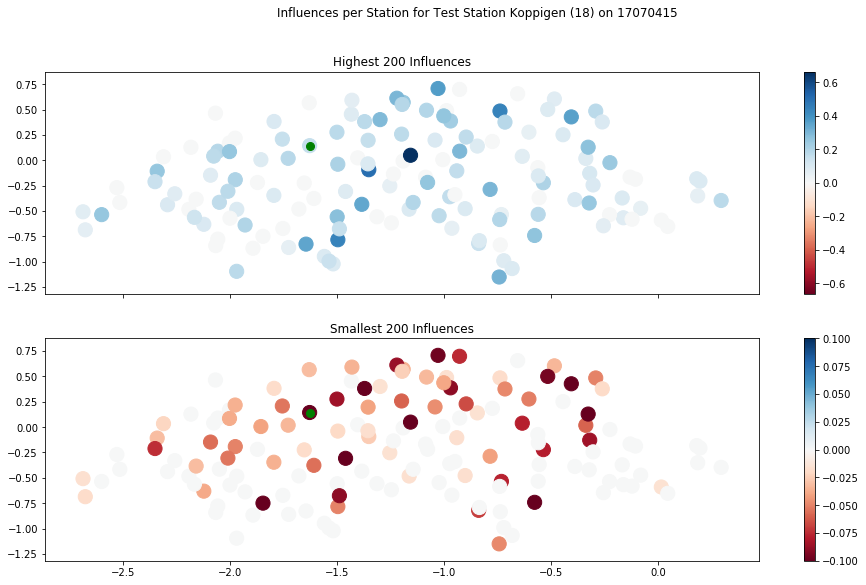

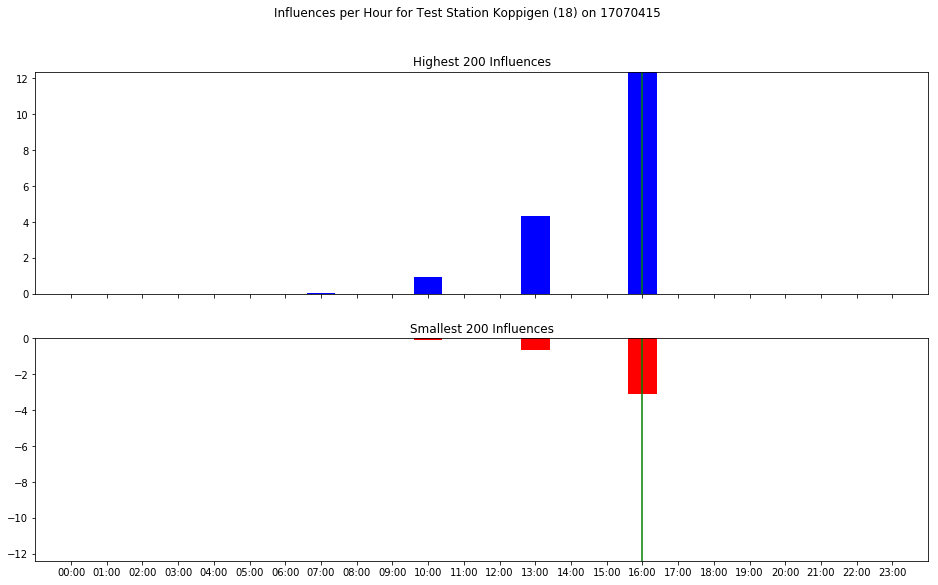

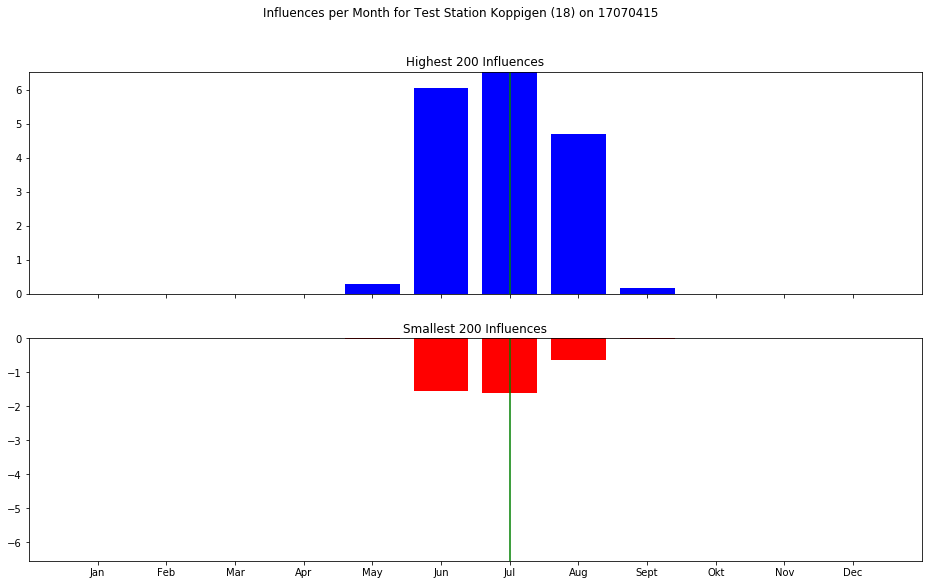

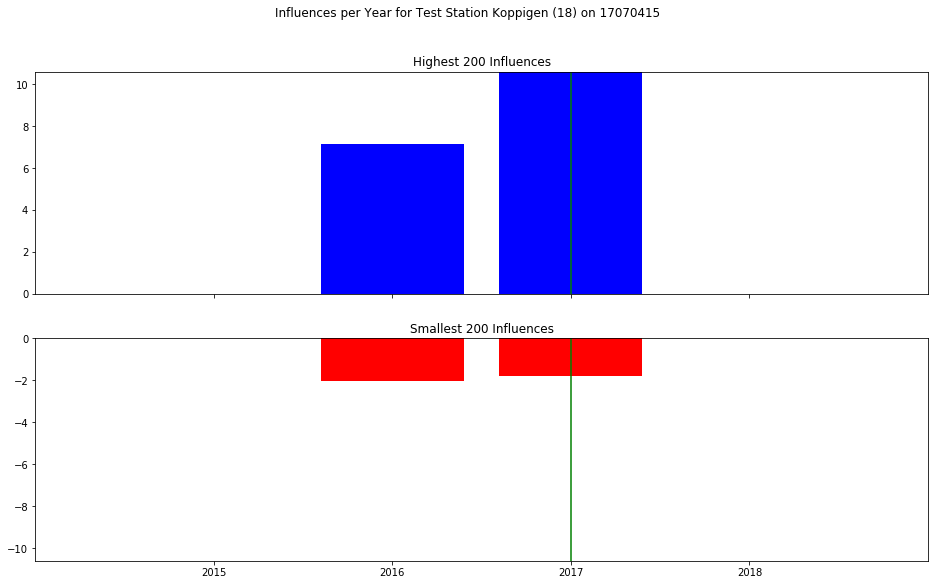

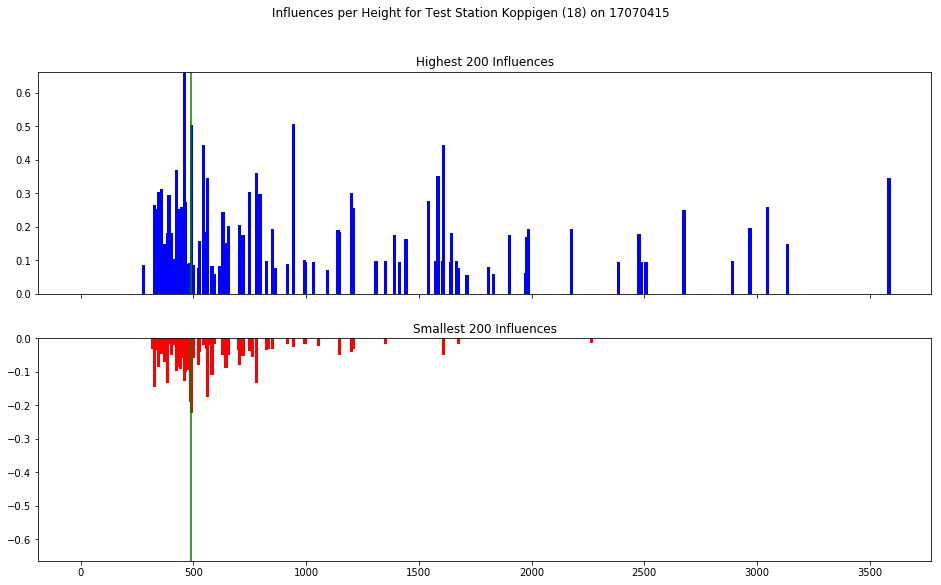

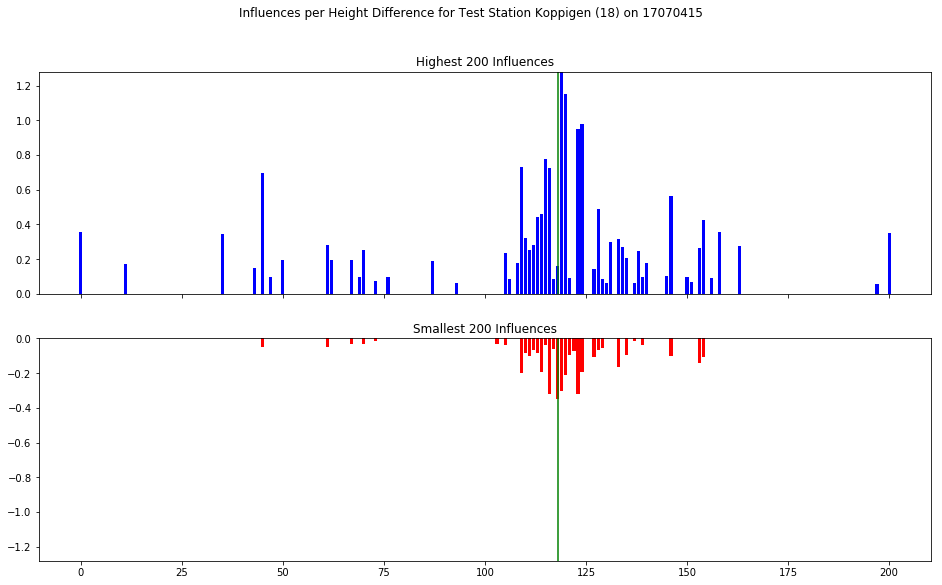

Bucket size:  0.3


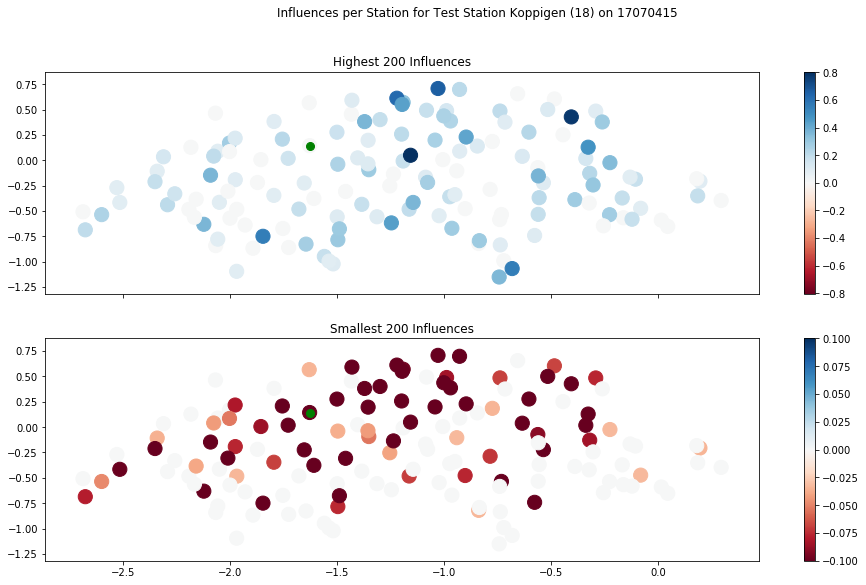

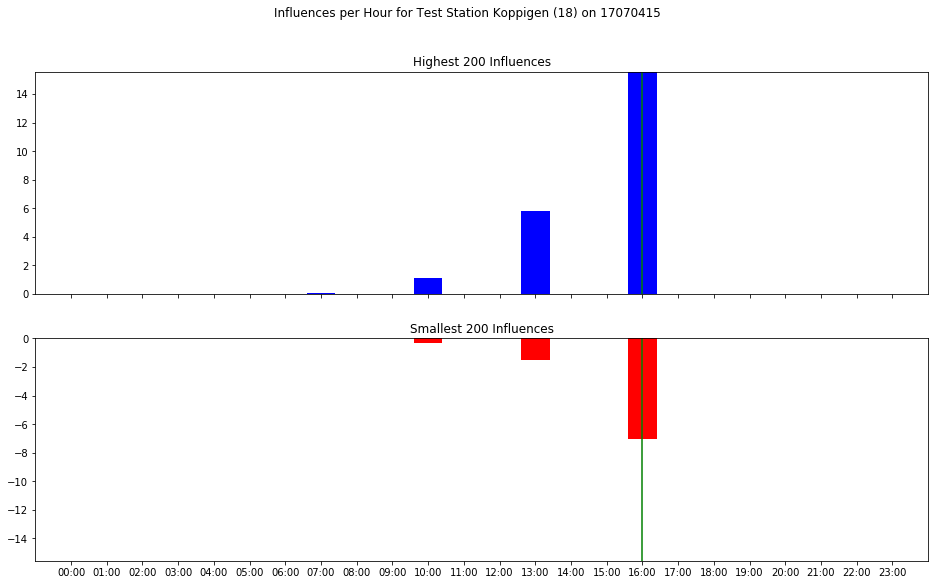

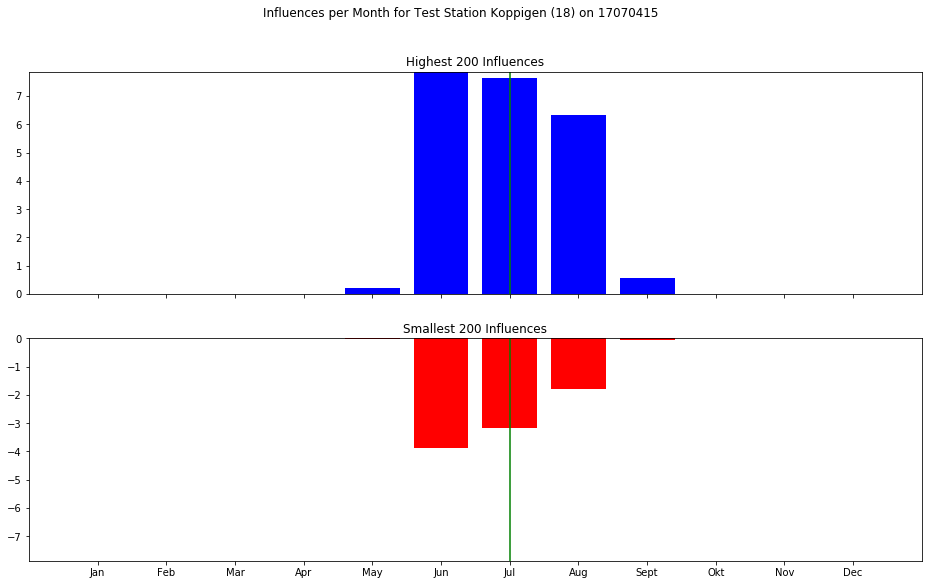

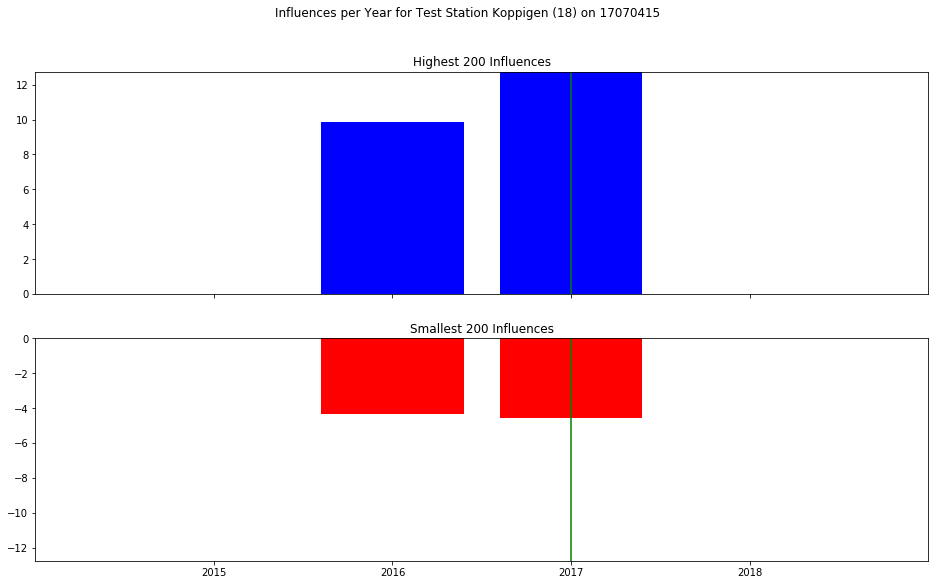

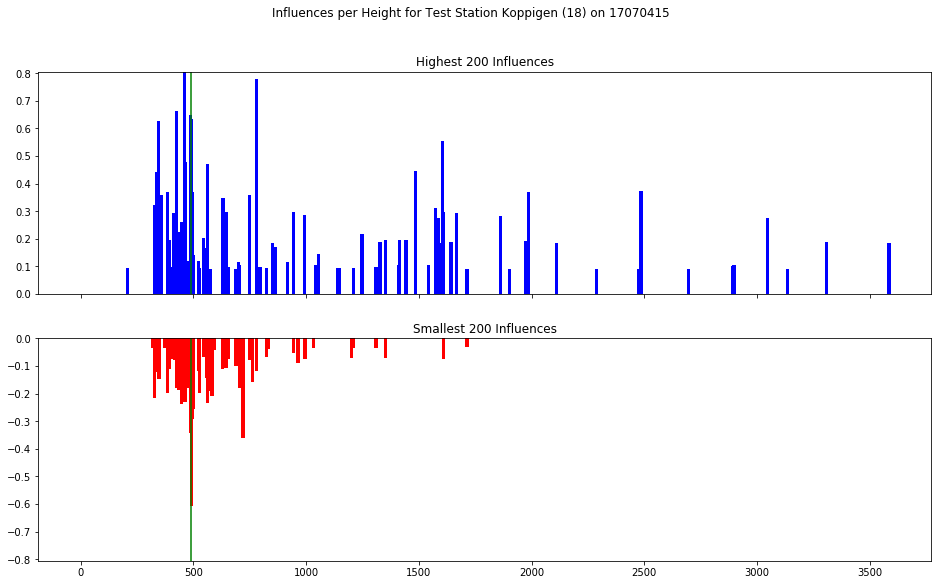

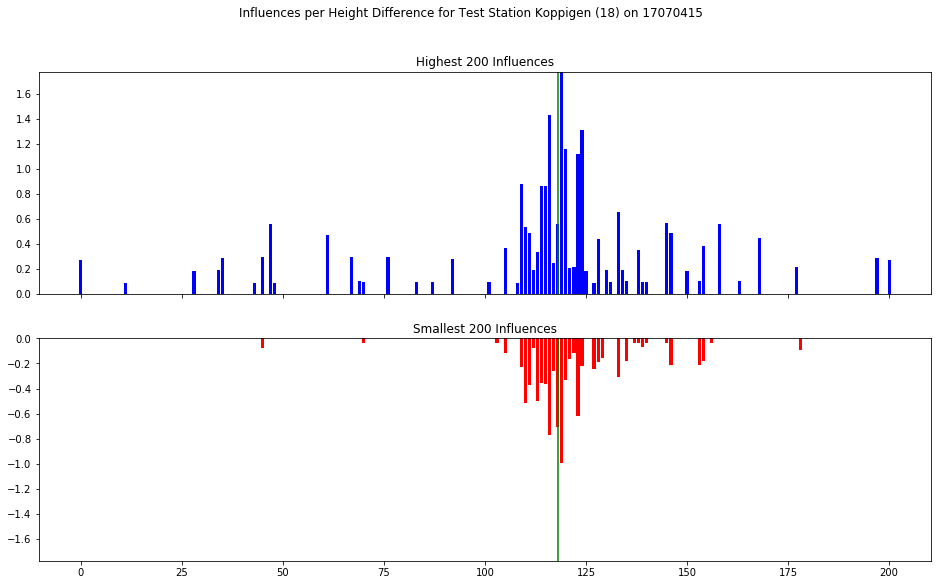

Bucket size:  0.5


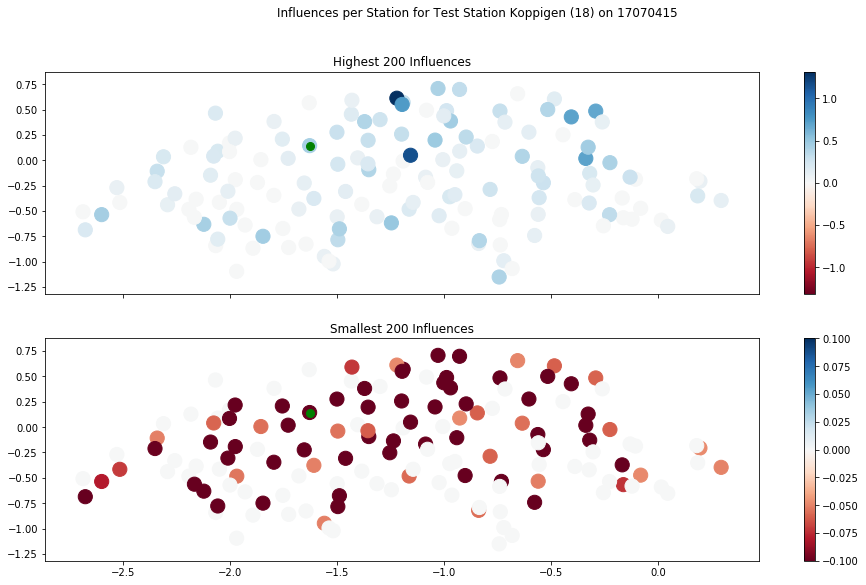

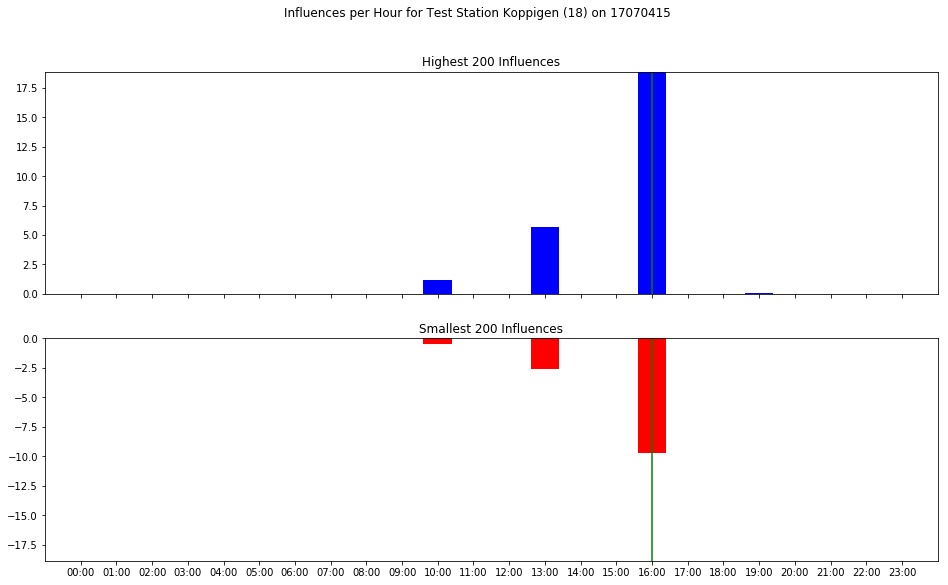

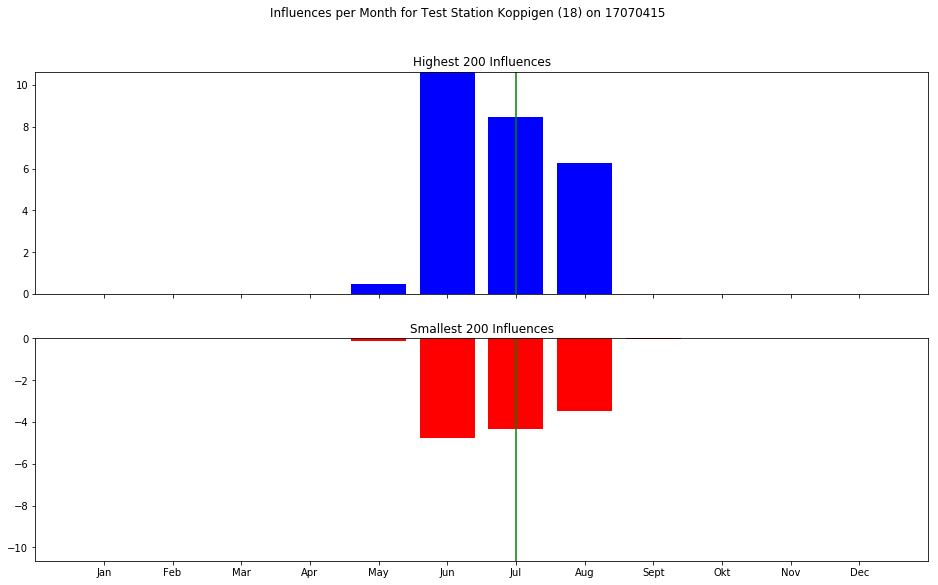

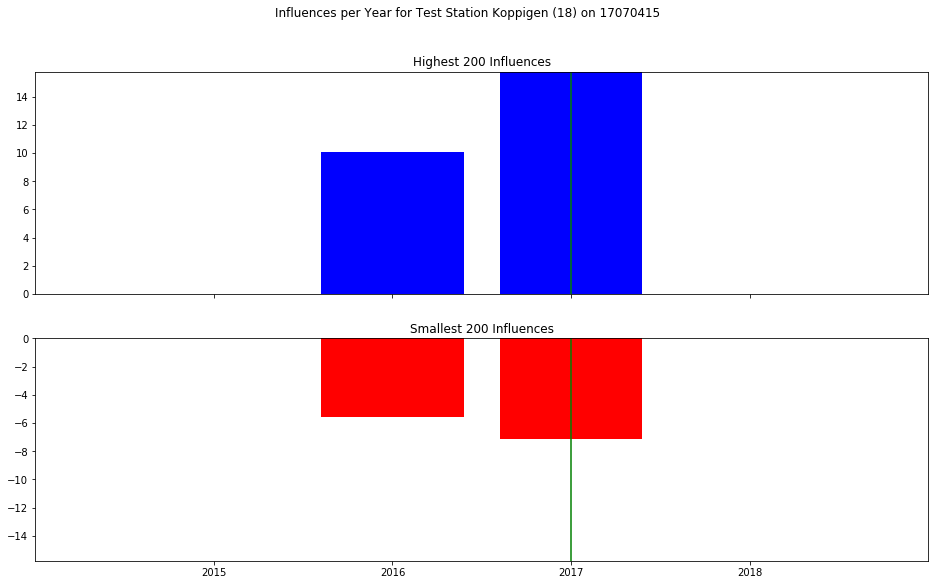

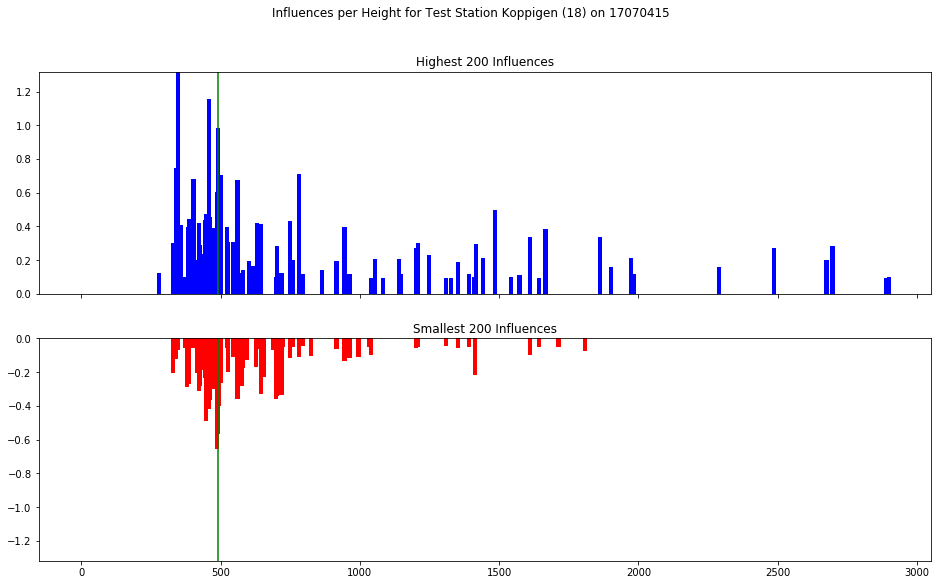

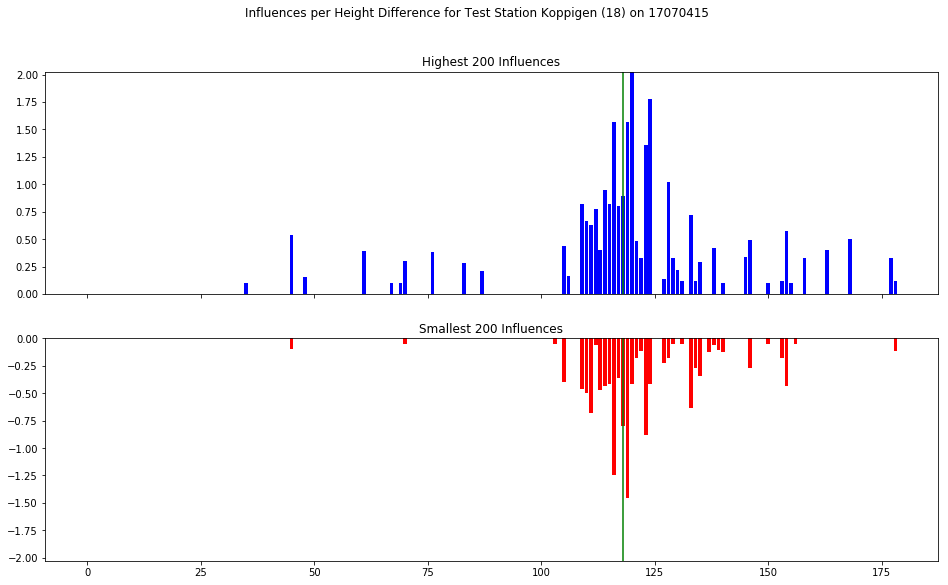

Bucket size:  1


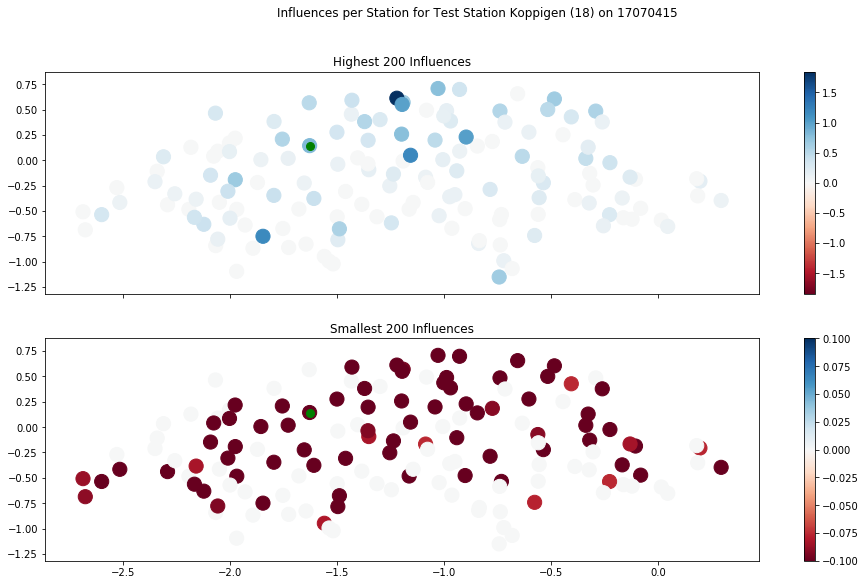

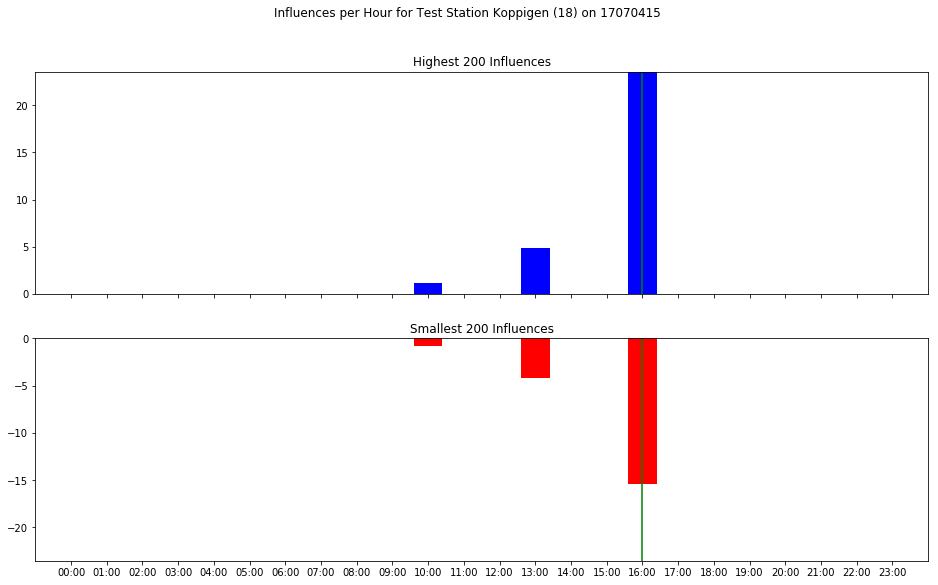

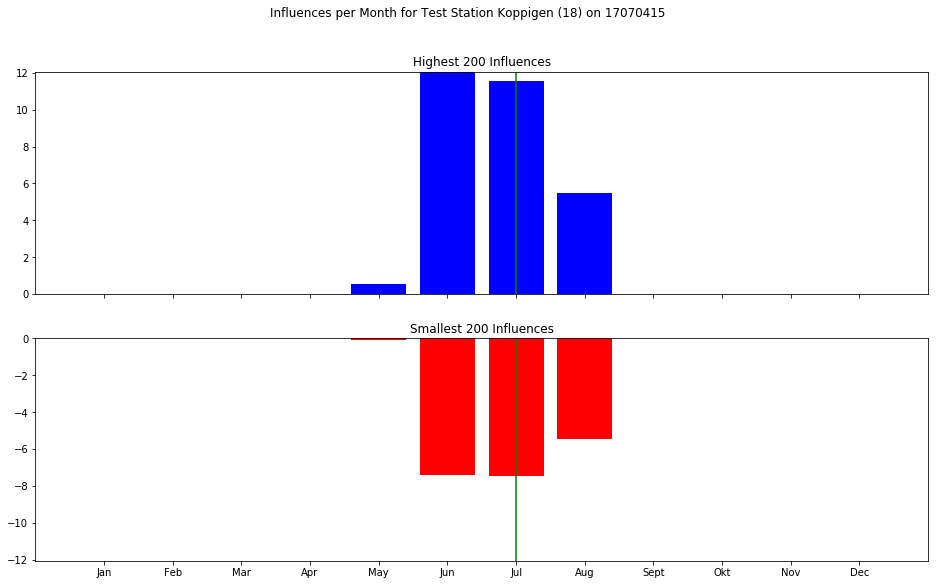

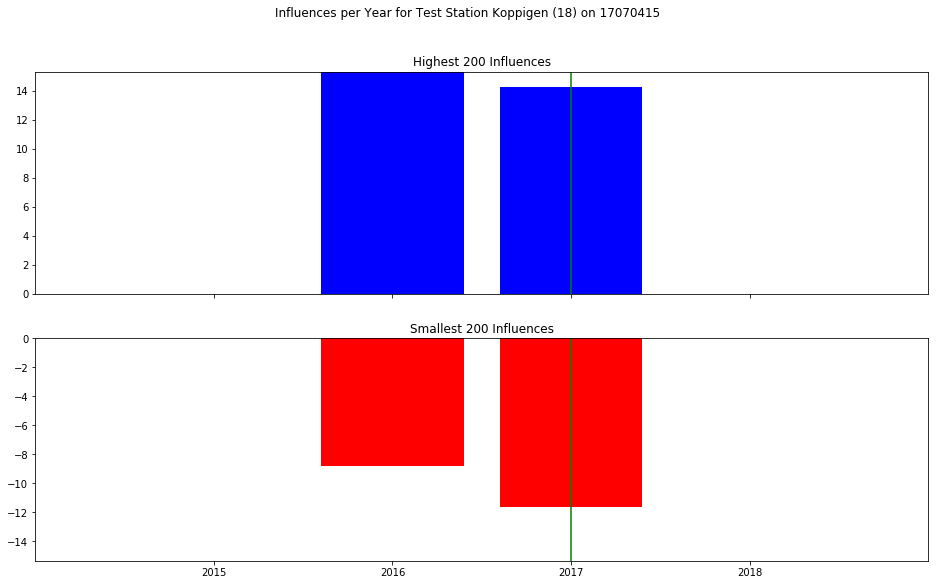

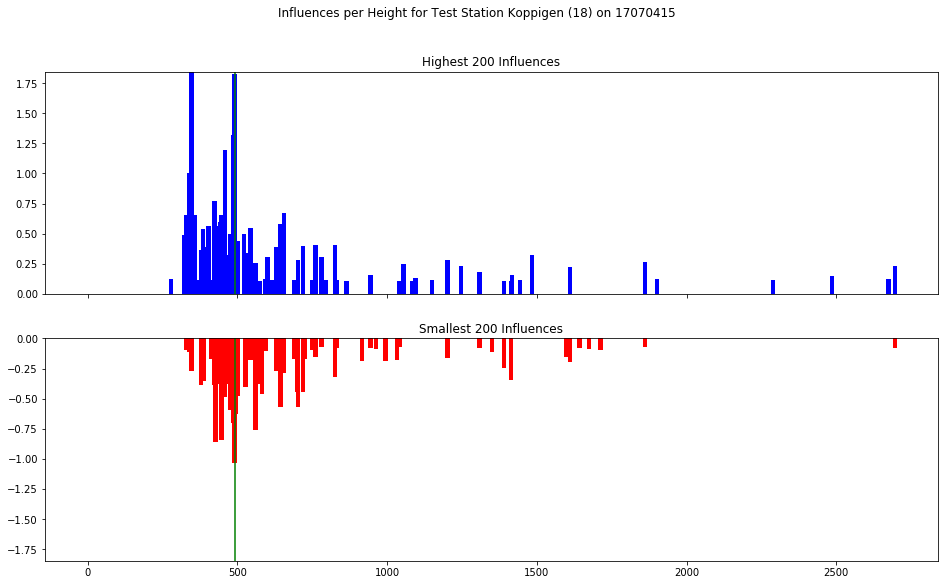

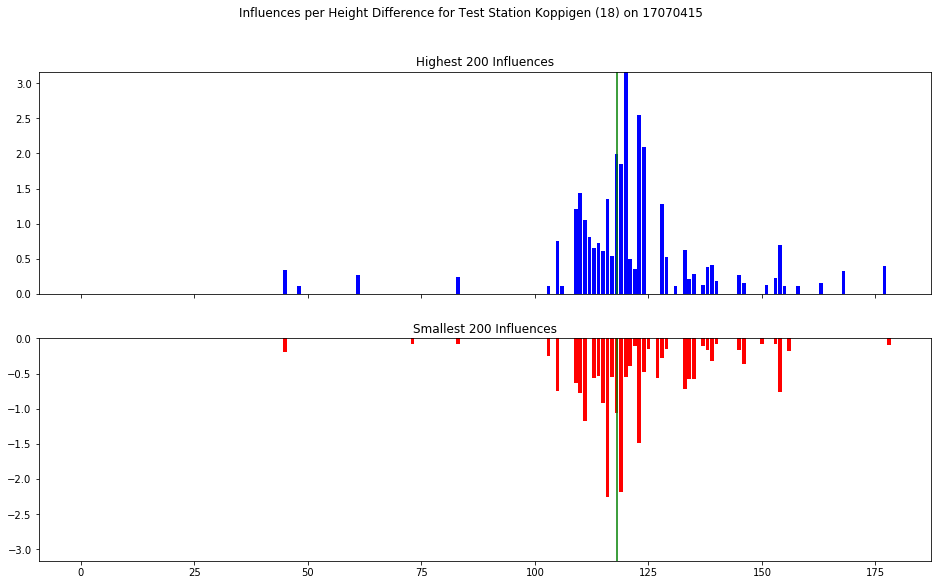

Bucket size:  2


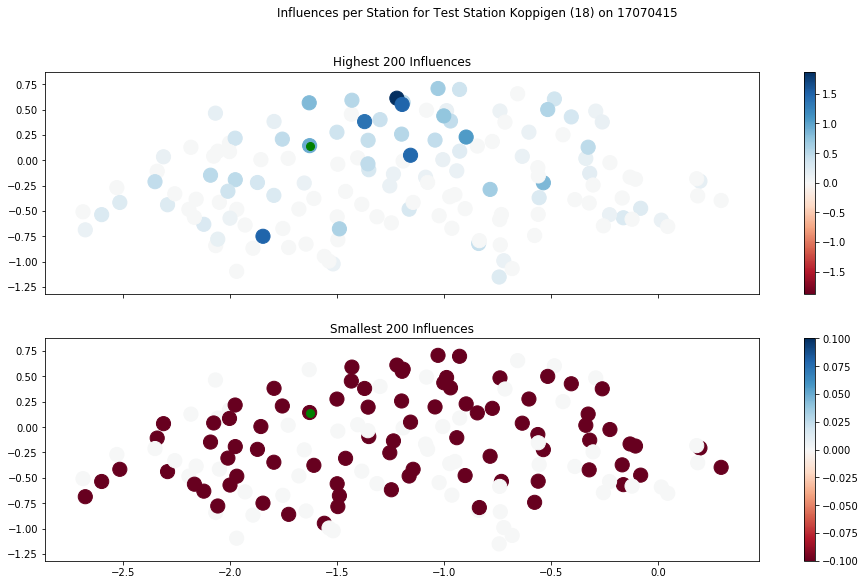

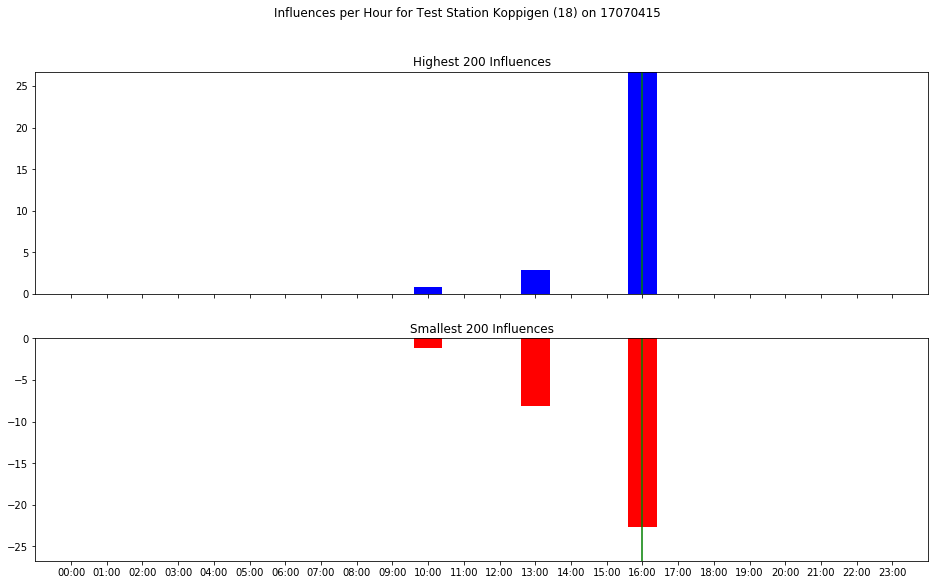

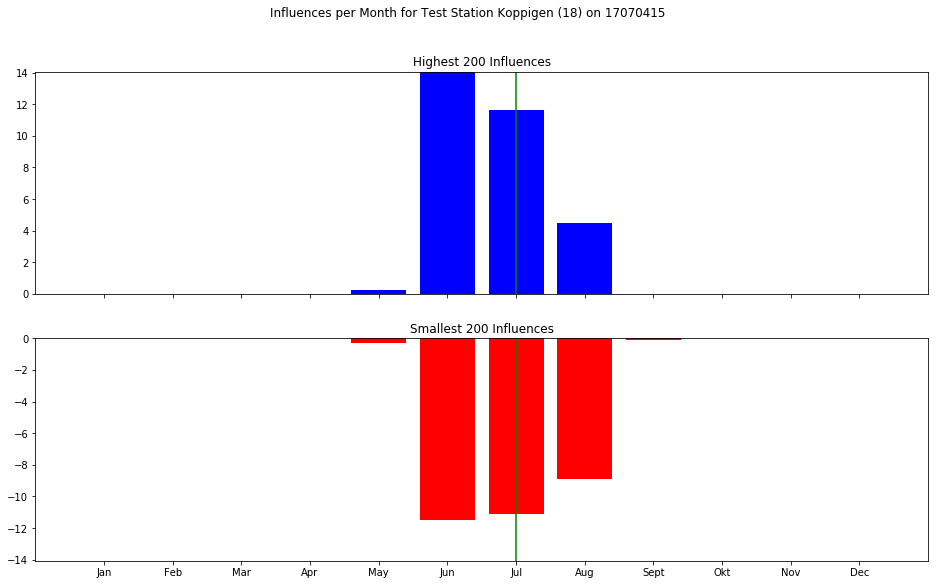

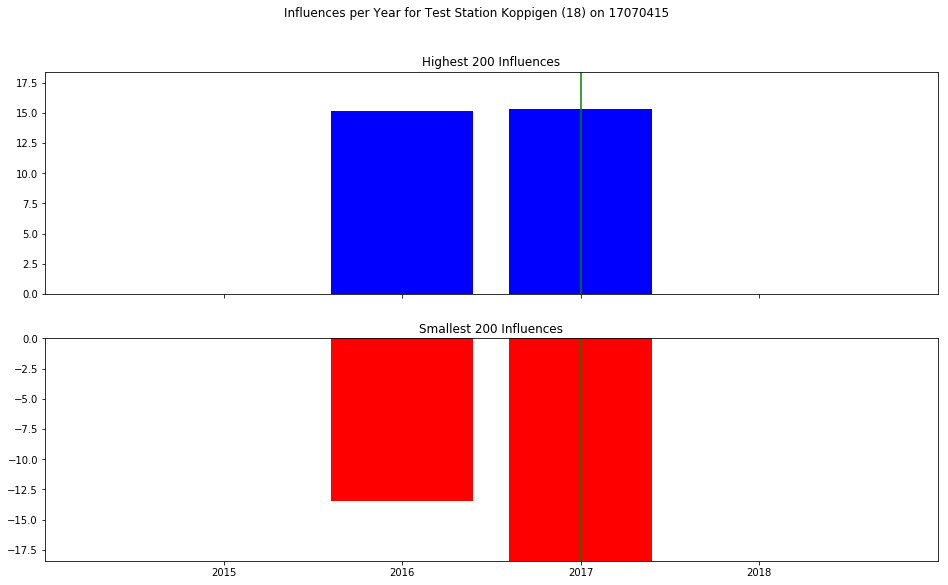

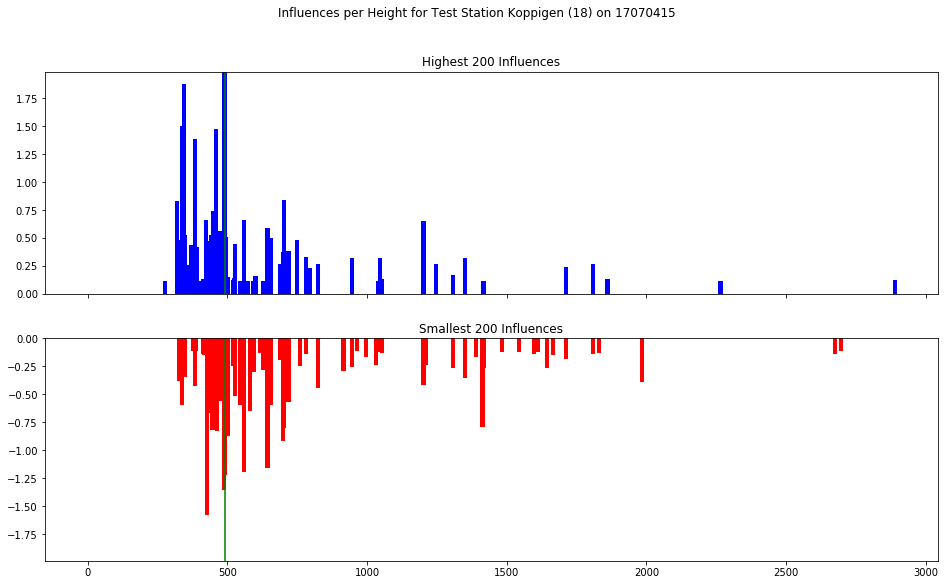

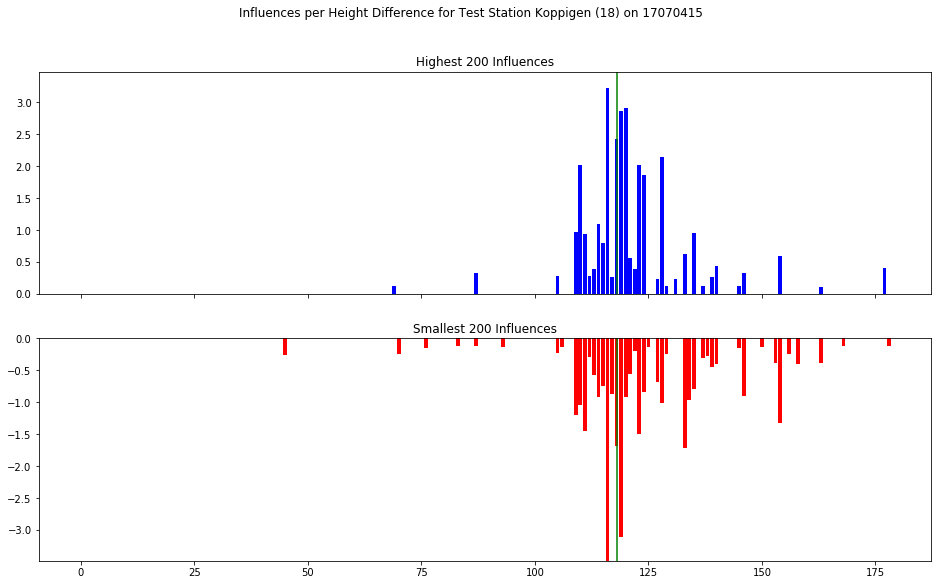

Bucket size:  5


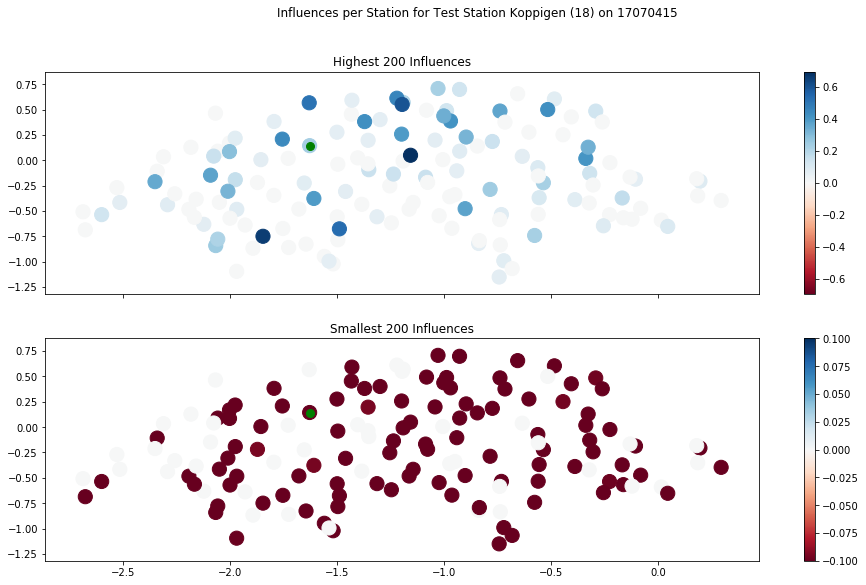

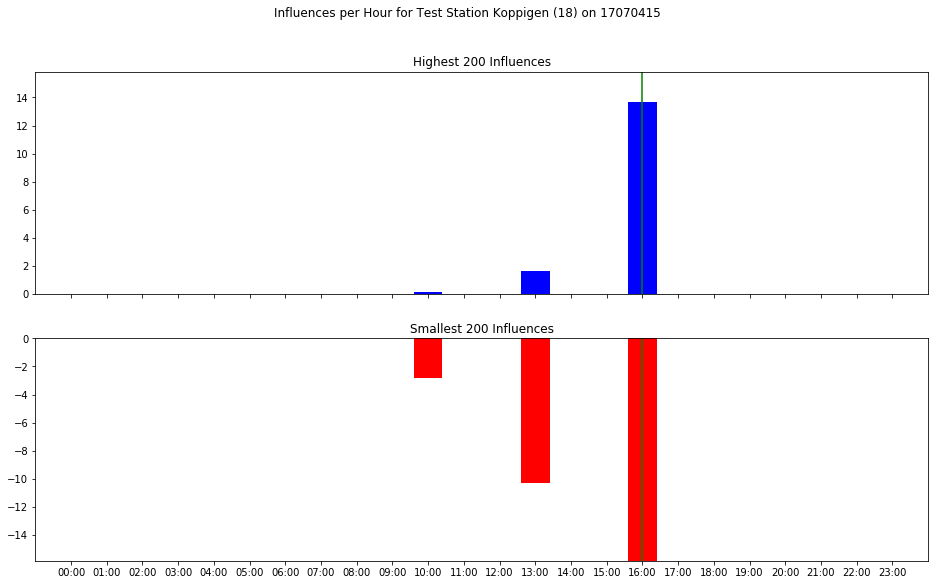

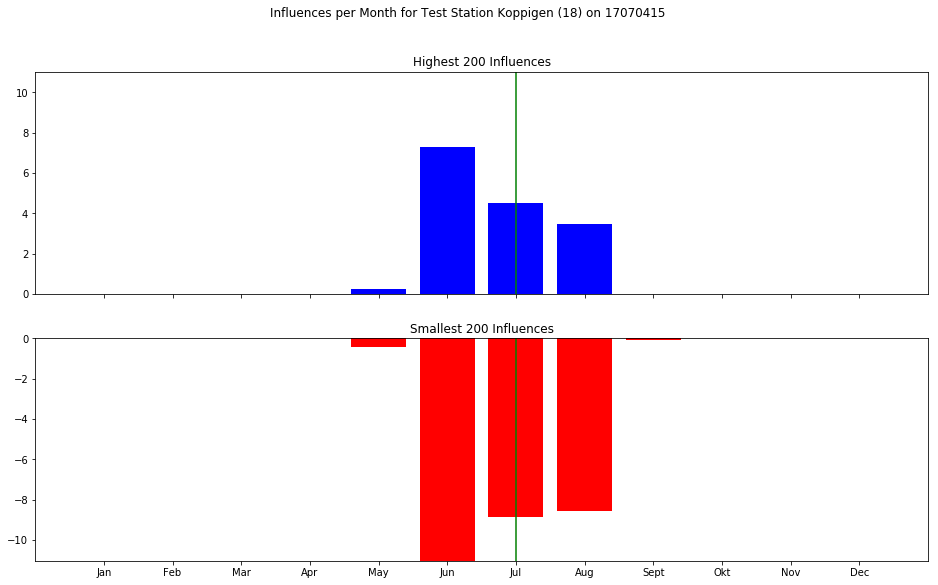

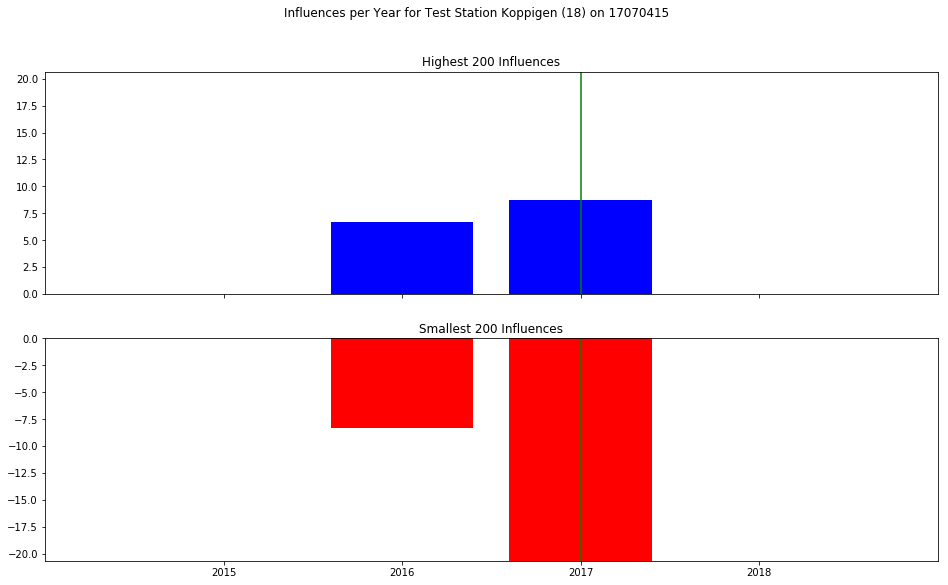

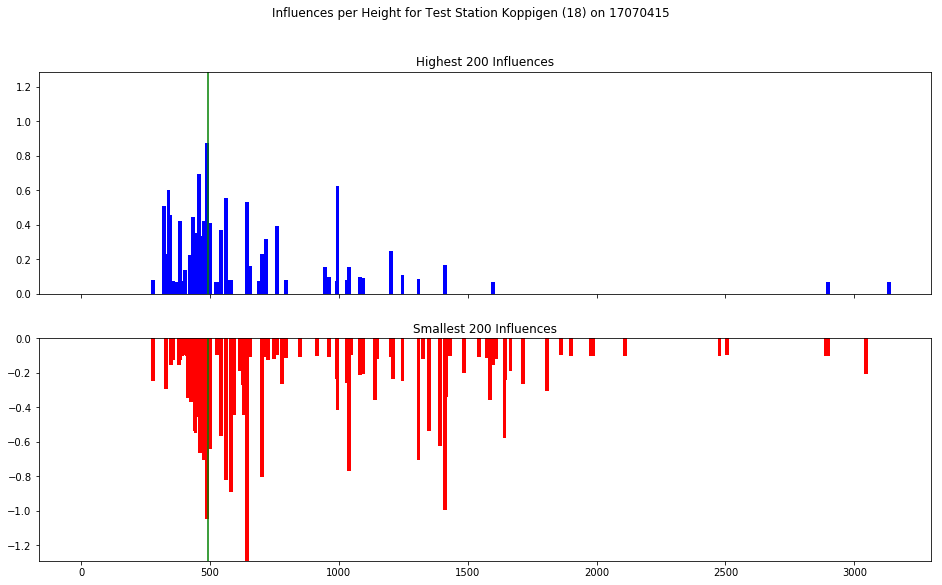

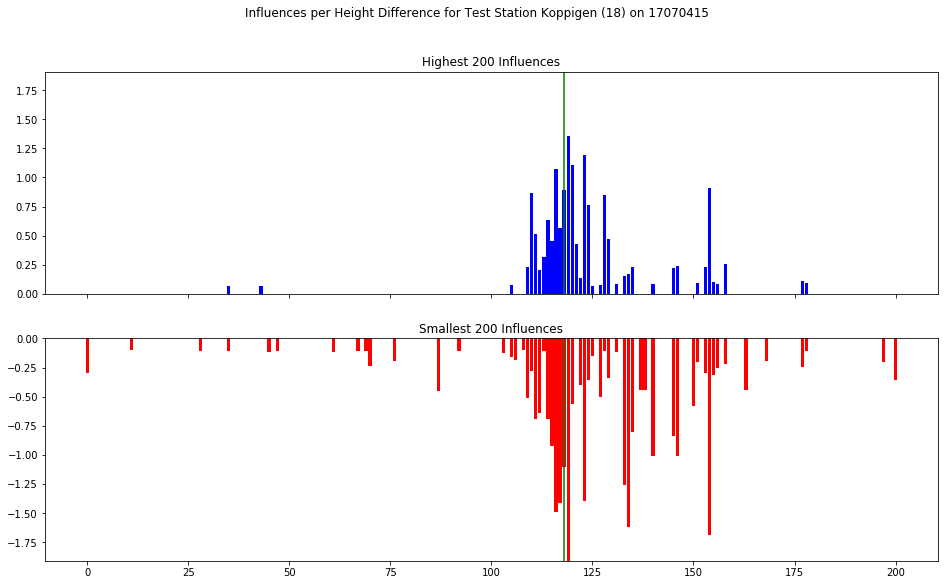

In [39]:
for idx, item in enumerate(shapley_results):
    print("Bucket size: ", item[0])
    plotTestIdxResultsWithWeightedInfluences(july_15_15_00_indices[0], item[1])

#### Bin size 0.1

In [ ]:
# adapt the labels to classes
min_label, max_label = np.minimum(np.min(Y_train_temp),np.min(Y_test_temp)), np.maximum(np.max(Y_train_temp),np.max(Y_test_temp))
n_classes = int(np.ceil((max_label - min_label)/0.1))
print(n_classes)

# the size of each bucket
size_of_bucket = (max_label - min_label)/n_classes

# we add two buckets that all sampels stay in the range on the left or right side, even if we shift the edges
bucket_edges = np.linspace(min_label-size_of_bucket,max_label+size_of_bucket,n_classes+3)

cetralize_function = lambda y: centralize_buckets_around_test_point(size_of_bucket, bucket_edges, False, y)

july_15_15_00_shapley_values_0_1 = run_knn(july_15_15_00_indices, Y_train_temp, Y_test_temp)

652
Calculation of knn values for test idx=31 took 22.7454674243927
Calculation of knn values for test idx=38 took 22.943422555923462
Calculation of knn values for test idx=124 took 22.682751417160034
Calculation of knn values for test idx=163 took 22.652179718017578
Calculation of knn values for test idx=190 took 22.362391710281372
Calculation of knn values for test idx=343 took 22.543004989624023
Calculation of knn values for test idx=385 took 22.525355339050293
Calculation of knn values for test idx=492 took 22.489601135253906
Calculation of knn values for test idx=565 took 22.534048318862915
Calculation of knn values for test idx=951 took 22.44474959373474
Calculation of knn values for test idx=1214 took 22.53060531616211
Calculation of knn values for test idx=1277 took 22.533114433288574
Calculation of knn values for test idx=1324 took 22.438478469848633
Calculation of knn values for test idx=1368 took 22.597315073013306
Calculation of knn values for test idx=1636 took 22.73341488

#### Bin size 0.3

In [ ]:
# adapt the labels to classes
min_label, max_label = np.minimum(np.min(Y_train_temp),np.min(Y_test_temp)), np.maximum(np.max(Y_train_temp),np.max(Y_test_temp))
n_classes = int(np.ceil((max_label - min_label)/0.3))
print(n_classes)

# the size of each bucket
size_of_bucket = (max_label - min_label)/n_classes

# we add two buckets that all sampels stay in the range on the left or right side, even if we shift the edges
bucket_edges = np.linspace(min_label-size_of_bucket,max_label+size_of_bucket,n_classes+3)

cetralize_function = lambda y: centralize_buckets_around_test_point(size_of_bucket, bucket_edges, False, y)

july_15_15_00_0_3 = run_knn(july_15_15_00_indices, Y_train_temp, Y_test_temp)

#### Bin size 0.5

In [ ]:
# adapt the labels to classes
min_label, max_label = np.minimum(np.min(Y_train_temp),np.min(Y_test_temp)), np.maximum(np.max(Y_train_temp),np.max(Y_test_temp))
n_classes = int(np.ceil((max_label - min_label)/0.5))
print(n_classes)

# the size of each bucket
size_of_bucket = (max_label - min_label)/n_classes

# we add two buckets that all sampels stay in the range on the left or right side, even if we shift the edges
bucket_edges = np.linspace(min_label-size_of_bucket,max_label+size_of_bucket,n_classes+3)

cetralize_function = lambda y: centralize_buckets_around_test_point(size_of_bucket, bucket_edges, False, y)

july_15_15_00_0_5 = run_knn(july_15_15_00_indices, Y_train_temp, Y_test_temp)

#### Bin size 1

In [ ]:
# adapt the labels to classes
min_label, max_label = np.minimum(np.min(Y_train_temp),np.min(Y_test_temp)), np.maximum(np.max(Y_train_temp),np.max(Y_test_temp))
n_classes = int(np.ceil((max_label - min_label)/1))
print(n_classes)

# the size of each bucket
size_of_bucket = (max_label - min_label)/n_classes

# we add two buckets that all sampels stay in the range on the left or right side, even if we shift the edges
bucket_edges = np.linspace(min_label-size_of_bucket,max_label+size_of_bucket,n_classes+3)

cetralize_function = lambda y: centralize_buckets_around_test_point(size_of_bucket, bucket_edges, False, y)

july_15_15_00_1_0 = run_knn(july_15_15_00_indices, Y_train_temp, Y_test_temp)

#### Bin size 2

In [ ]:
# adapt the labels to classes
min_label, max_label = np.minimum(np.min(Y_train_temp),np.min(Y_test_temp)), np.maximum(np.max(Y_train_temp),np.max(Y_test_temp))
n_classes = int(np.ceil((max_label - min_label)/2))
print(n_classes)

# the size of each bucket
size_of_bucket = (max_label - min_label)/n_classes

# we add two buckets that all sampels stay in the range on the left or right side, even if we shift the edges
bucket_edges = np.linspace(min_label-size_of_bucket,max_label+size_of_bucket,n_classes+3)

cetralize_function = lambda y: centralize_buckets_around_test_point(size_of_bucket, bucket_edges, False, y)

july_15_15_00_2_0 = run_knn(july_15_15_00_indices, Y_train_temp, Y_test_temp)

#### Bin size 5

In [ ]:
# adapt the labels to classes
min_label, max_label = np.minimum(np.min(Y_train_temp),np.min(Y_test_temp)), np.maximum(np.max(Y_train_temp),np.max(Y_test_temp))
n_classes = int(np.ceil((max_label - min_label)/5))
print(n_classes)

# the size of each bucket
size_of_bucket = (max_label - min_label)/n_classes

# we add two buckets that all sampels stay in the range on the left or right side, even if we shift the edges
bucket_edges = np.linspace(min_label-size_of_bucket,max_label+size_of_bucket,n_classes+3)

cetralize_function = lambda y: centralize_buckets_around_test_point(size_of_bucket, bucket_edges, False, y)

july_15_15_00_5_0 = run_knn([july_15_15_00_indices], Y_train_temp, Y_test_temp)

## Calculate Shapley Vales with different Bucket Sizes For Best Station & Init

#### Best forecast skill over inits and stations in test set
Best Init.: 13.08.2016 09:00, Station: Vaduz, Forecast Skill = 100.00%<br>
Model absolute Error = 2.479553e-05, COSMO-1 absolute Error: 1.225244
Init. Idx = 330, Station Idx = 30, Station Id = 36

In [92]:
best_forecast_test_idx = test_data_set.loc[(test_data_set['Init'] == '16081309') & (test_data_set['Station'] == 30)].index[0]

#### Bin size 0.1

652
Calculation of knn values for test idx=98189 took 23.493239164352417


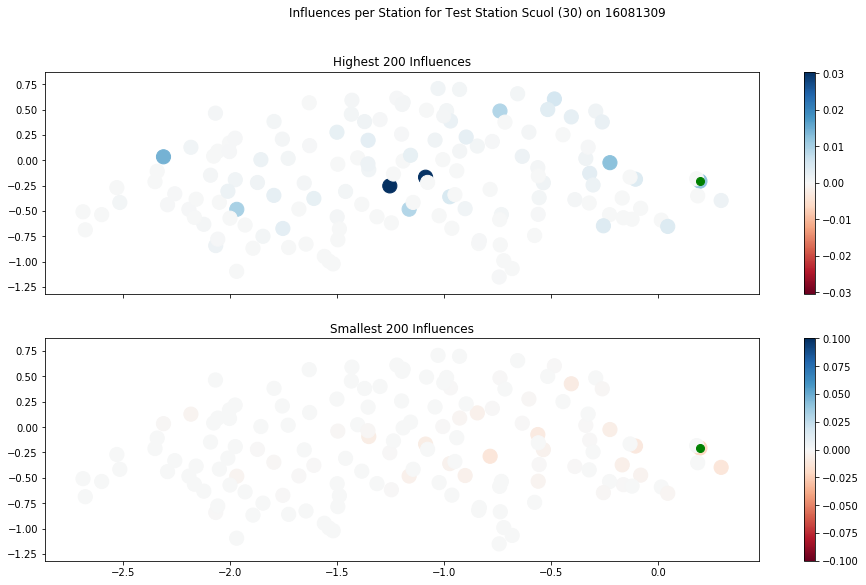

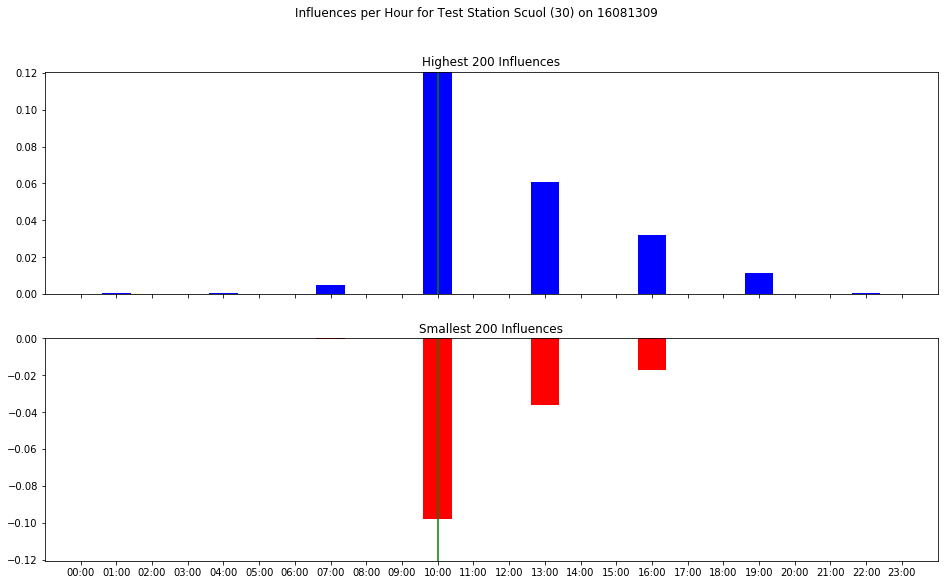

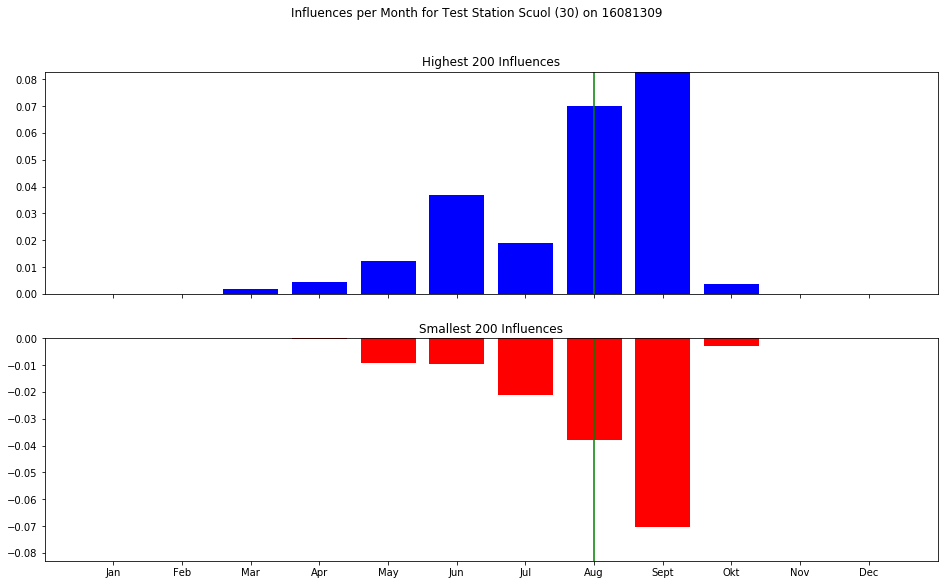

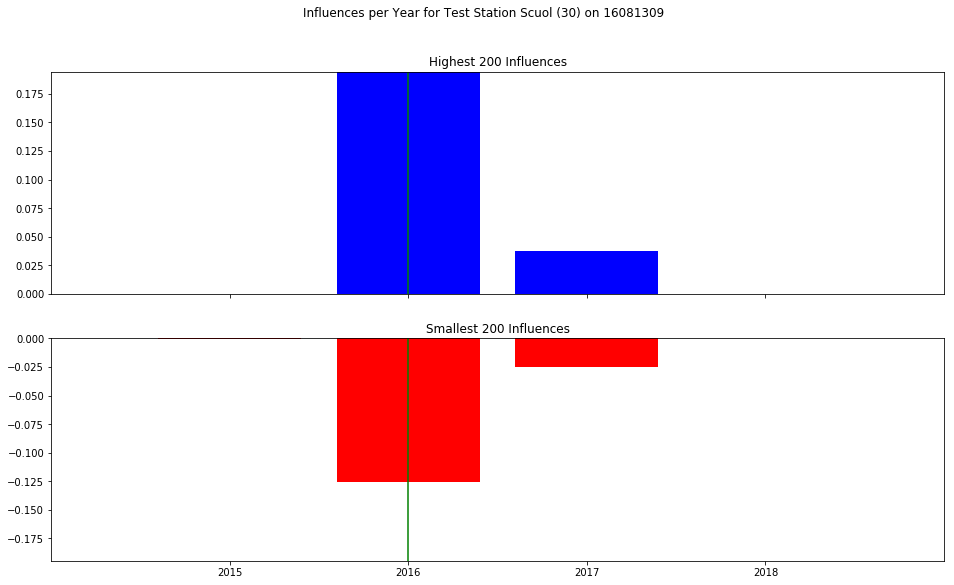

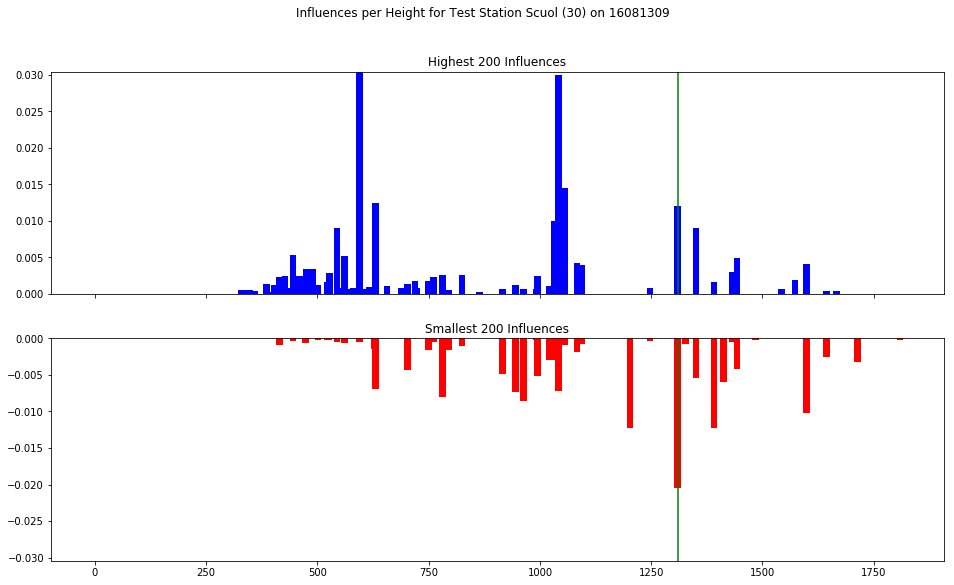

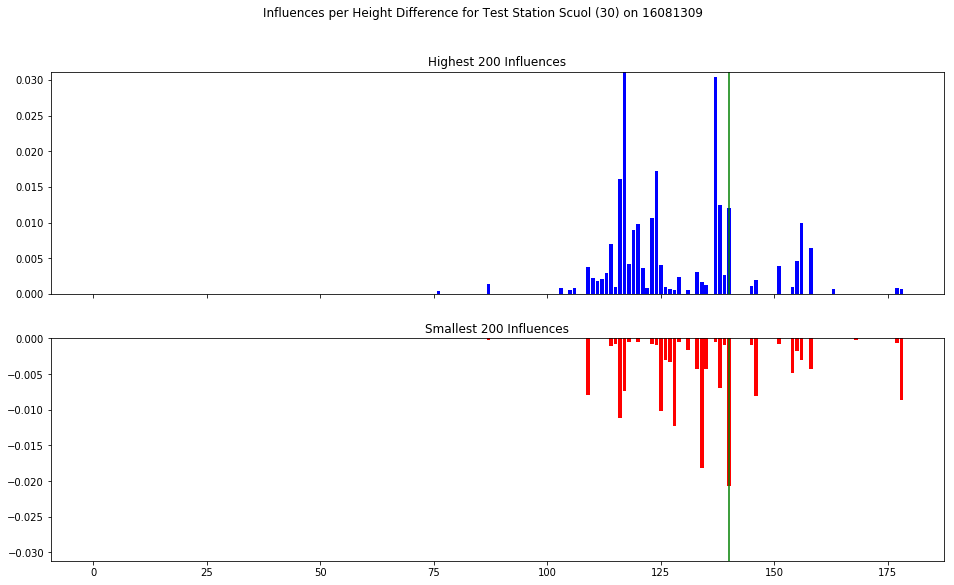

In [93]:
# adapt the labels to classes
min_label, max_label = np.minimum(np.min(Y_train_temp),np.min(Y_test_temp)), np.maximum(np.max(Y_train_temp),np.max(Y_test_temp))
n_classes = int(np.ceil((max_label - min_label)/0.1))
print(n_classes)

# the size of each bucket
size_of_bucket = (max_label - min_label)/n_classes

# we add two buckets that all sampels stay in the range on the left or right side, even if we shift the edges
bucket_edges = np.linspace(min_label-size_of_bucket,max_label+size_of_bucket,n_classes+3)

cetralize_function = lambda y: centralize_buckets_around_test_point(size_of_bucket, bucket_edges, False, y)

shapley_values_0_1 = run_knn([best_forecast_test_idx], Y_train_temp, Y_test_temp)
plotTestIdxResultsWithWeightedInfluences(best_forecast_test_idx, shapley_values_0_1)

#### Bin size 0.3

218
Calculation of knn values for test idx=98189 took 23.423980951309204


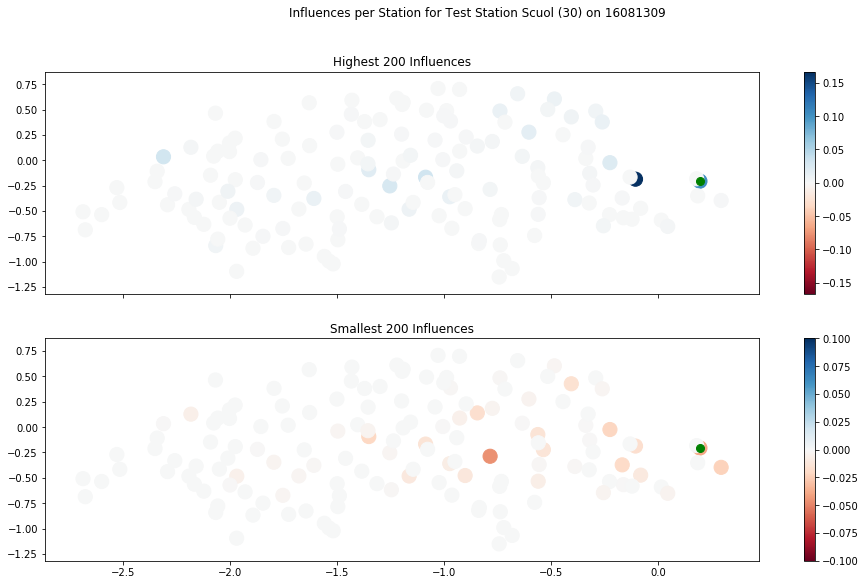

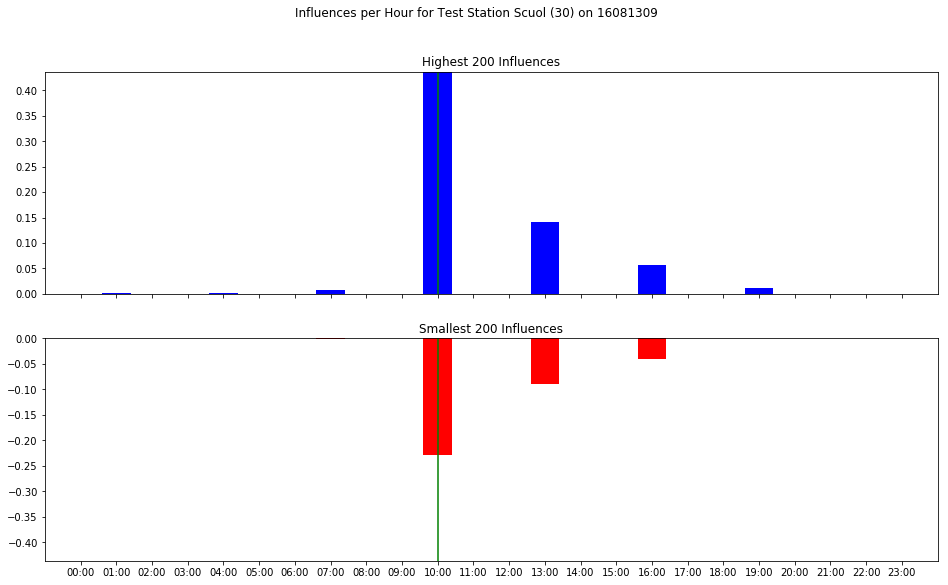

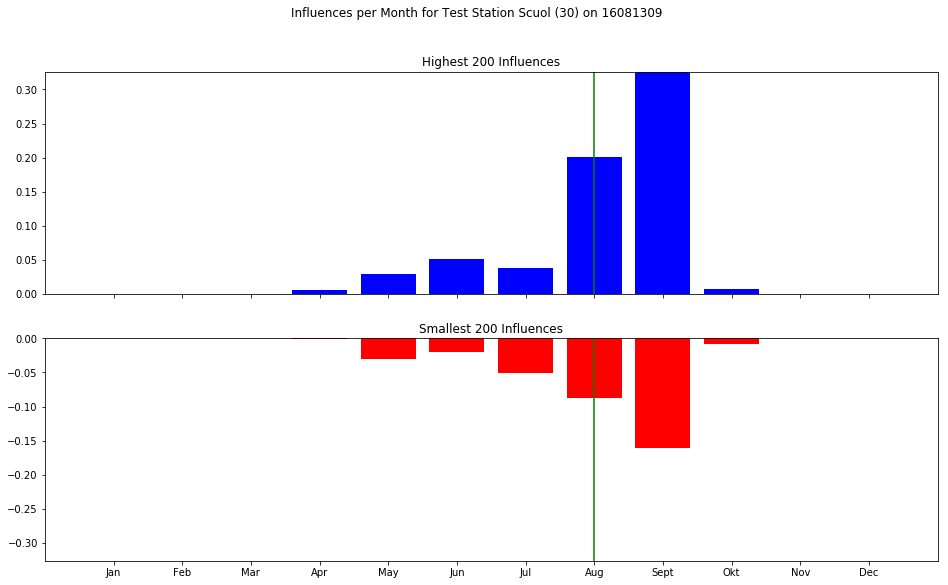

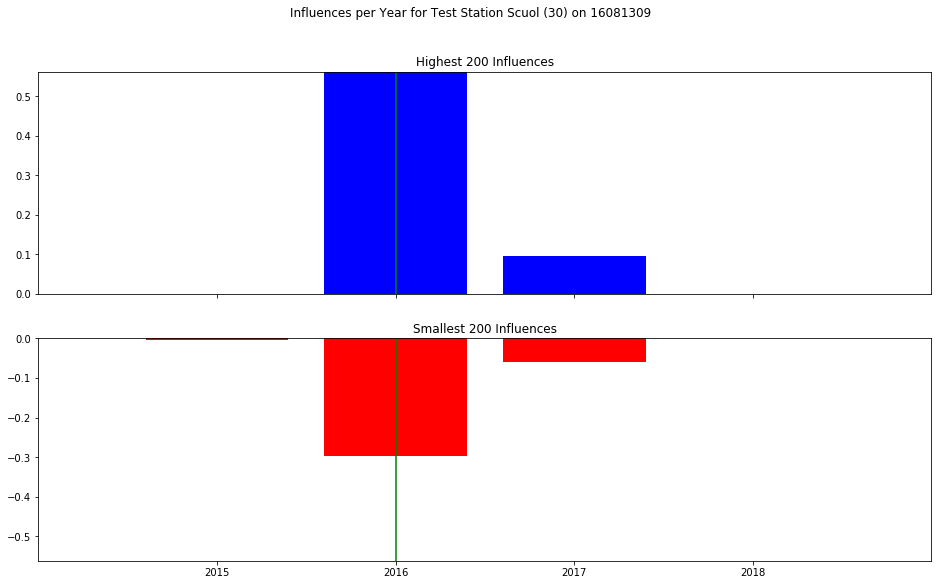

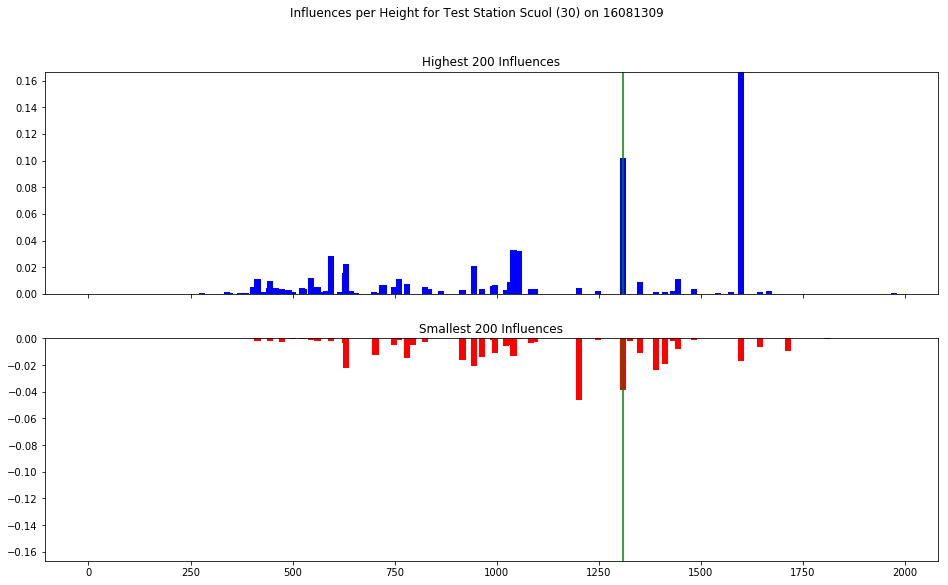

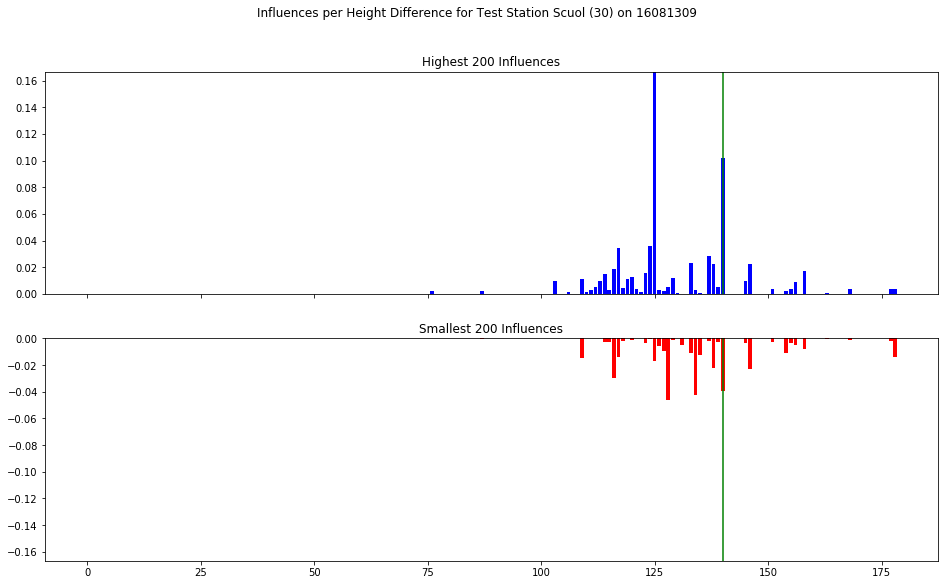

In [94]:
# adapt the labels to classes
min_label, max_label = np.minimum(np.min(Y_train_temp),np.min(Y_test_temp)), np.maximum(np.max(Y_train_temp),np.max(Y_test_temp))
n_classes = int(np.ceil((max_label - min_label)/0.3))
print(n_classes)

# the size of each bucket
size_of_bucket = (max_label - min_label)/n_classes

# we add two buckets that all sampels stay in the range on the left or right side, even if we shift the edges
bucket_edges = np.linspace(min_label-size_of_bucket,max_label+size_of_bucket,n_classes+3)

cetralize_function = lambda y: centralize_buckets_around_test_point(size_of_bucket, bucket_edges, False, y)

shapley_values_0_3 = run_knn([best_forecast_test_idx], Y_train_temp, Y_test_temp)
plotTestIdxResultsWithWeightedInfluences(best_forecast_test_idx, shapley_values_0_3)

#### Bin size 0.5

131
Calculation of knn values for test idx=98189 took 22.848592042922974


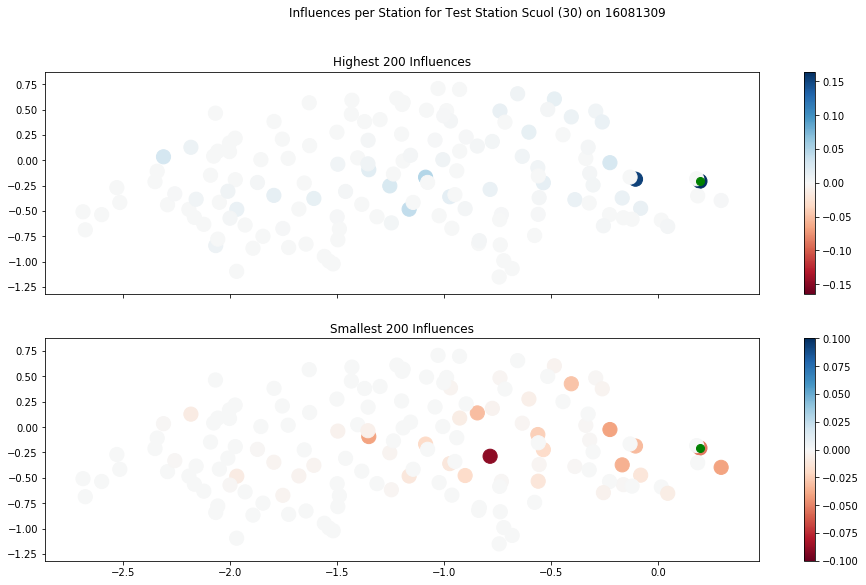

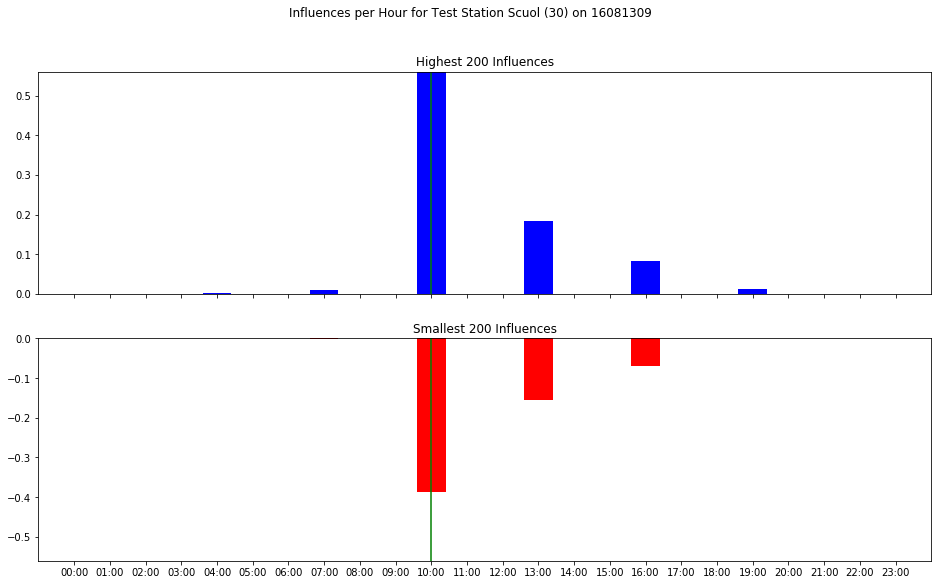

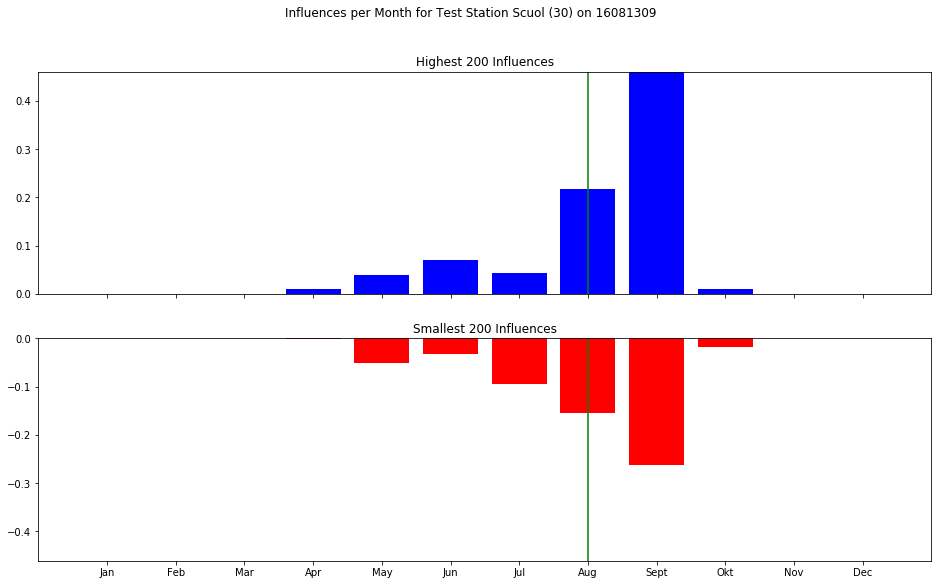

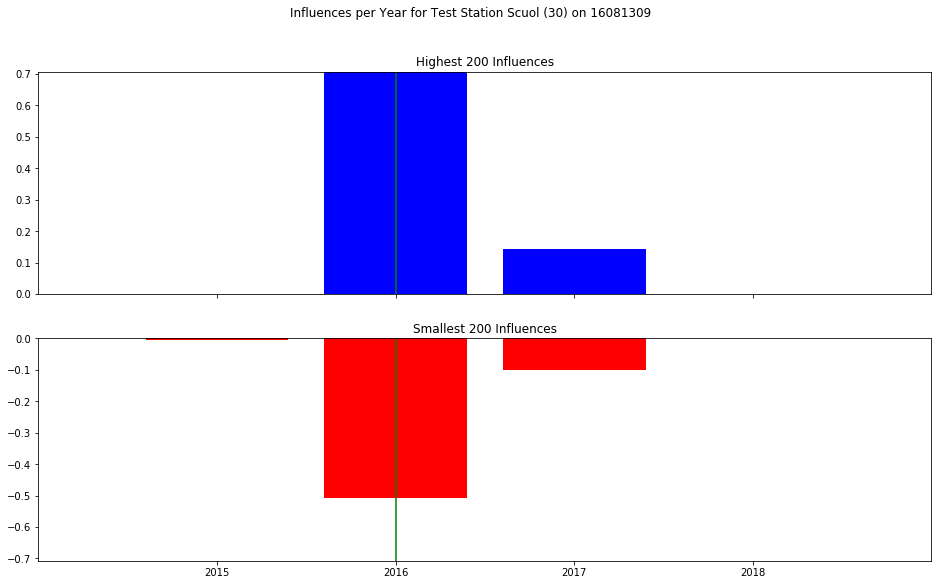

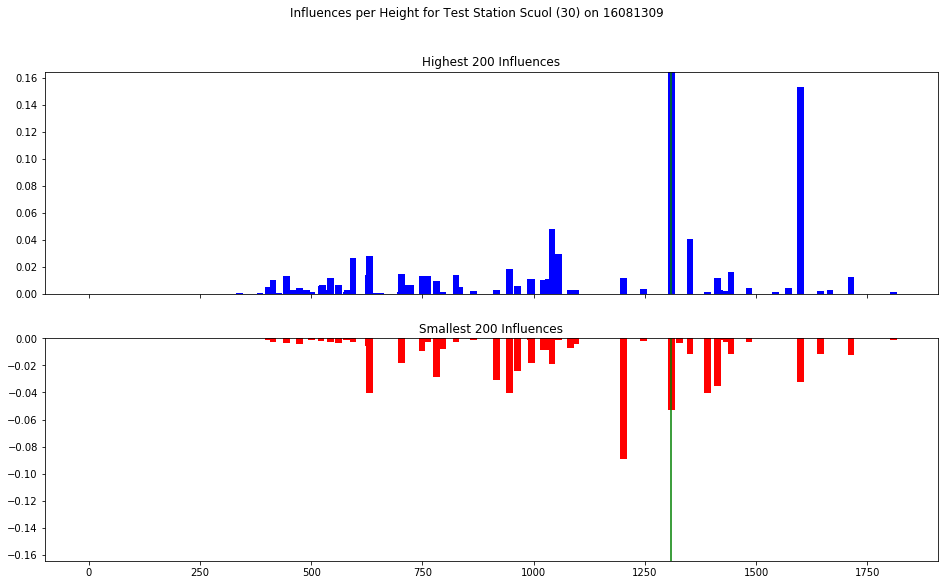

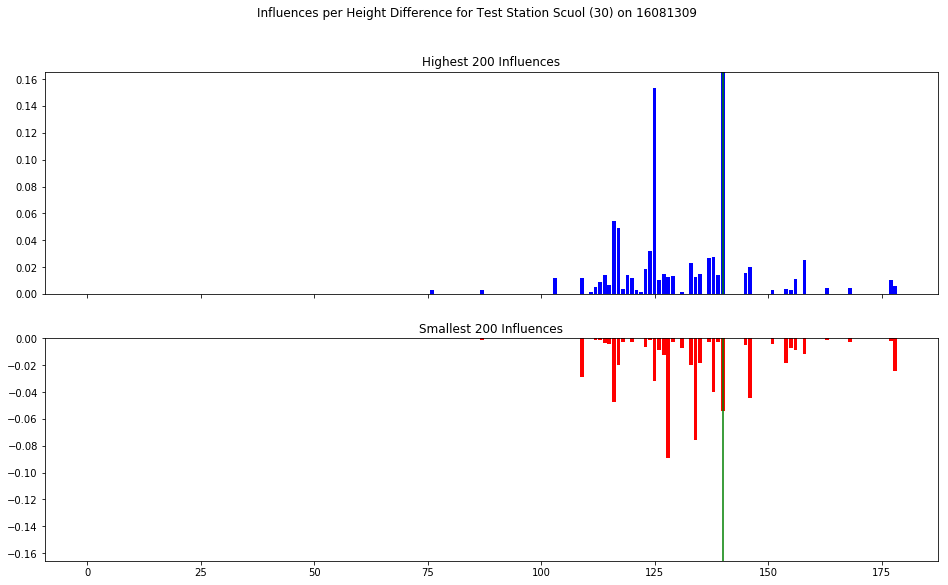

In [95]:
# adapt the labels to classes
min_label, max_label = np.minimum(np.min(Y_train_temp),np.min(Y_test_temp)), np.maximum(np.max(Y_train_temp),np.max(Y_test_temp))
n_classes = int(np.ceil((max_label - min_label)/0.5))
print(n_classes)

# the size of each bucket
size_of_bucket = (max_label - min_label)/n_classes

# we add two buckets that all sampels stay in the range on the left or right side, even if we shift the edges
bucket_edges = np.linspace(min_label-size_of_bucket,max_label+size_of_bucket,n_classes+3)

cetralize_function = lambda y: centralize_buckets_around_test_point(size_of_bucket, bucket_edges, False, y)

shapley_values_0_5 = run_knn([best_forecast_test_idx], Y_train_temp, Y_test_temp)
plotTestIdxResultsWithWeightedInfluences(best_forecast_test_idx, shapley_values_0_5)

#### Bin size 1

66
Calculation of knn values for test idx=98189 took 22.80648922920227


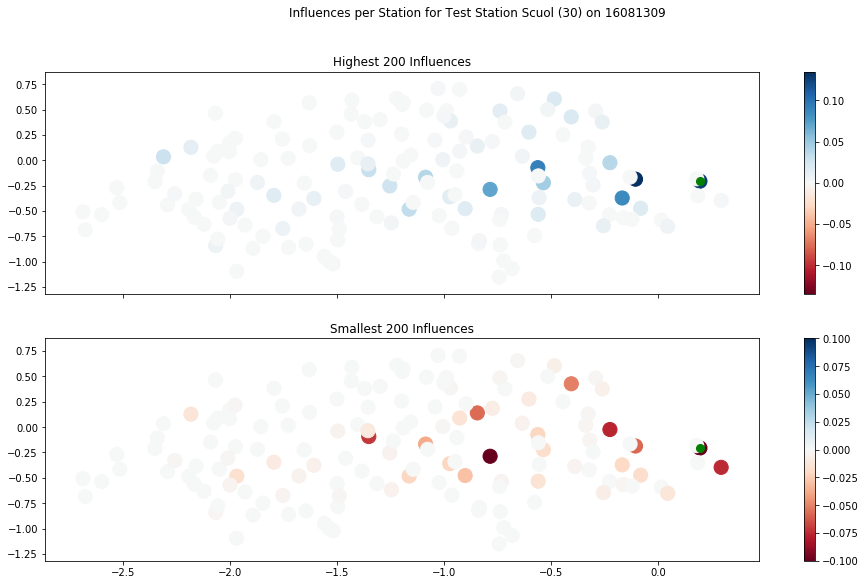

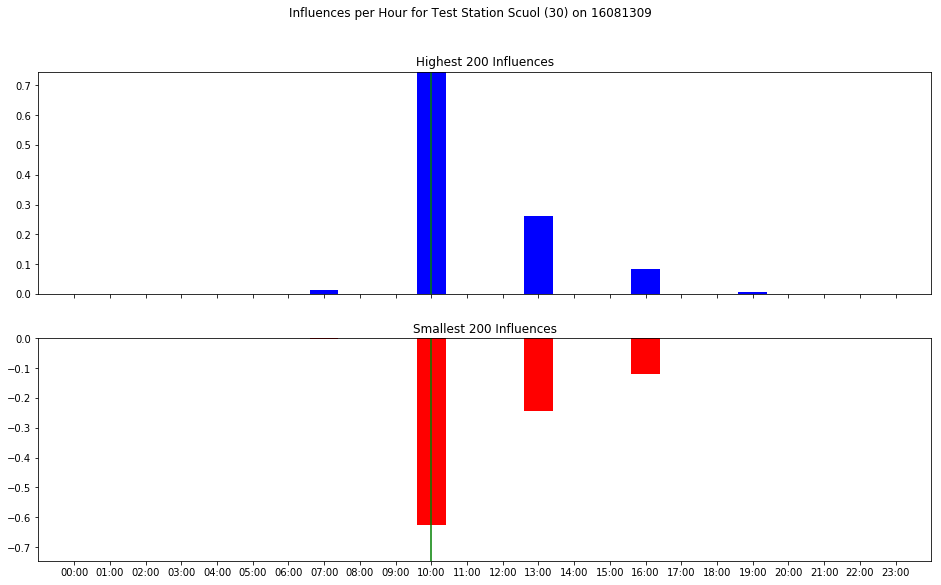

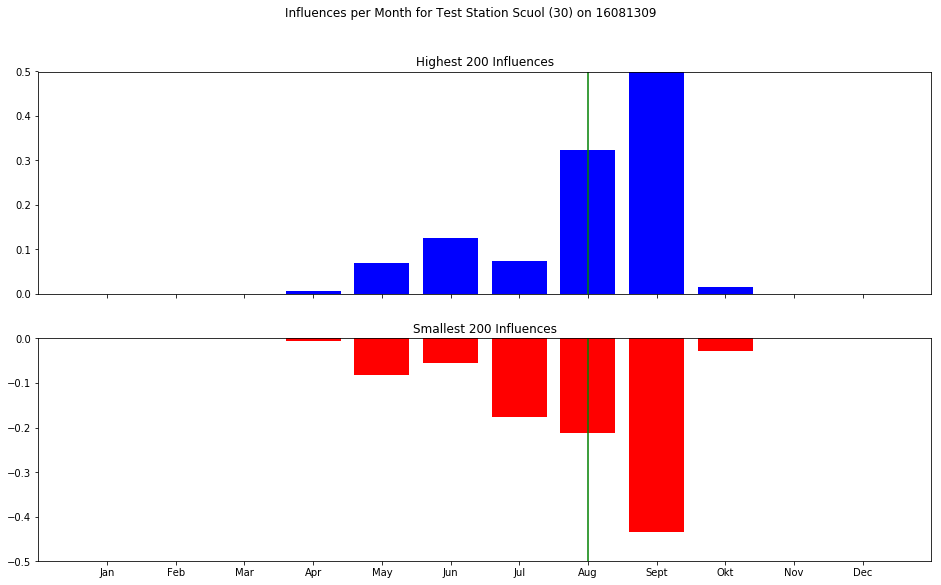

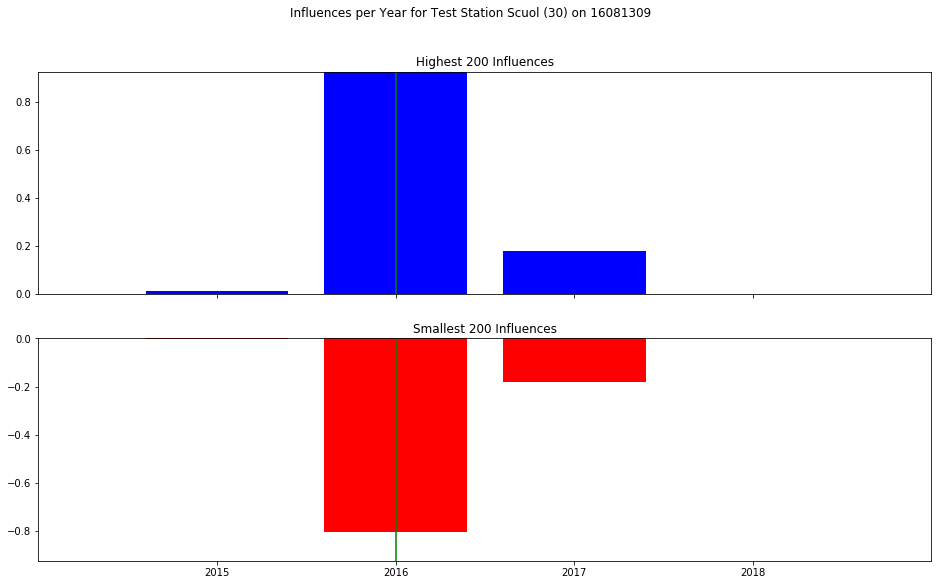

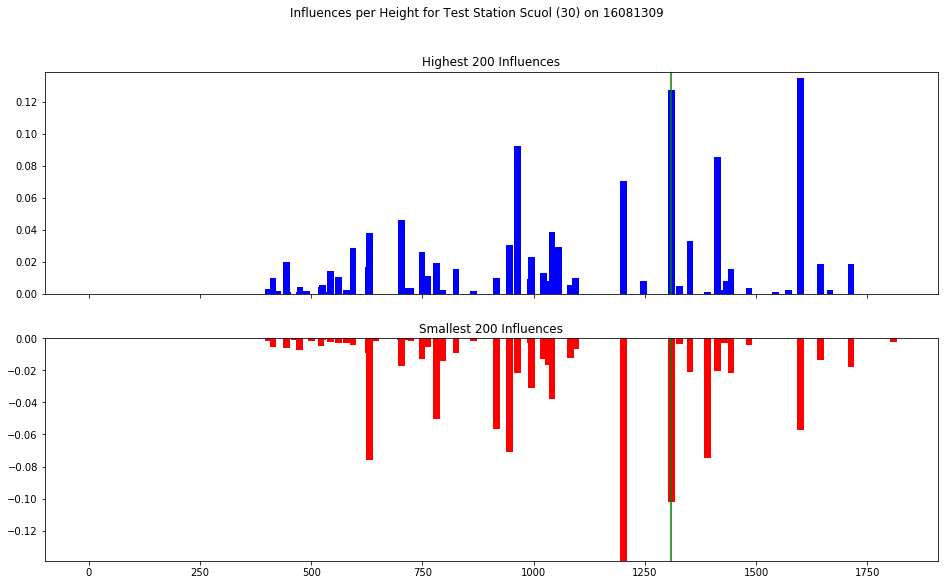

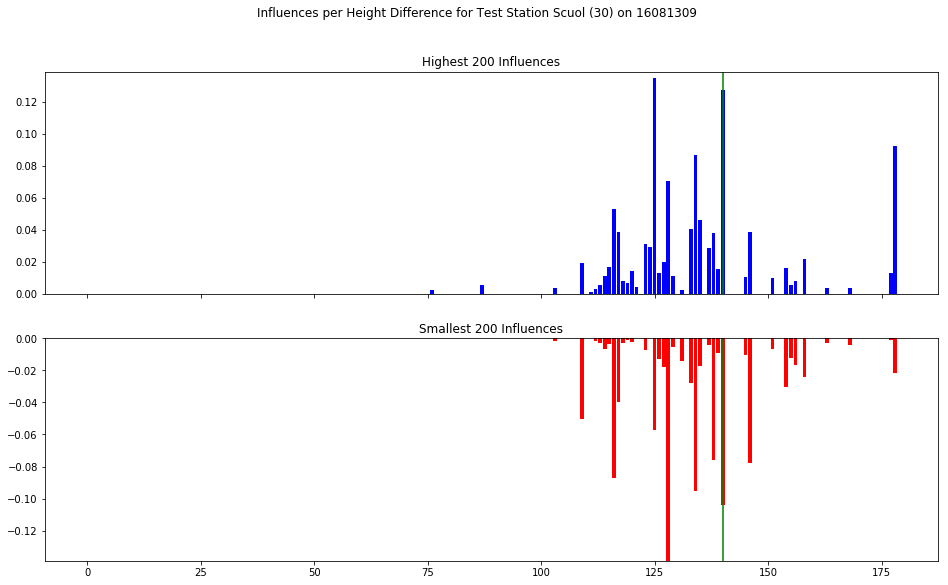

In [96]:
# adapt the labels to classes
min_label, max_label = np.minimum(np.min(Y_train_temp),np.min(Y_test_temp)), np.maximum(np.max(Y_train_temp),np.max(Y_test_temp))
n_classes = int(np.ceil((max_label - min_label)/1))
print(n_classes)

# the size of each bucket
size_of_bucket = (max_label - min_label)/n_classes

# we add two buckets that all sampels stay in the range on the left or right side, even if we shift the edges
bucket_edges = np.linspace(min_label-size_of_bucket,max_label+size_of_bucket,n_classes+3)

cetralize_function = lambda y: centralize_buckets_around_test_point(size_of_bucket, bucket_edges, False, y)

shapley_values_1_0 = run_knn([best_forecast_test_idx], Y_train_temp, Y_test_temp)
plotTestIdxResultsWithWeightedInfluences(best_forecast_test_idx, shapley_values_1_0)

#### Bin size 2

33
Calculation of knn values for test idx=98189 took 22.989945650100708


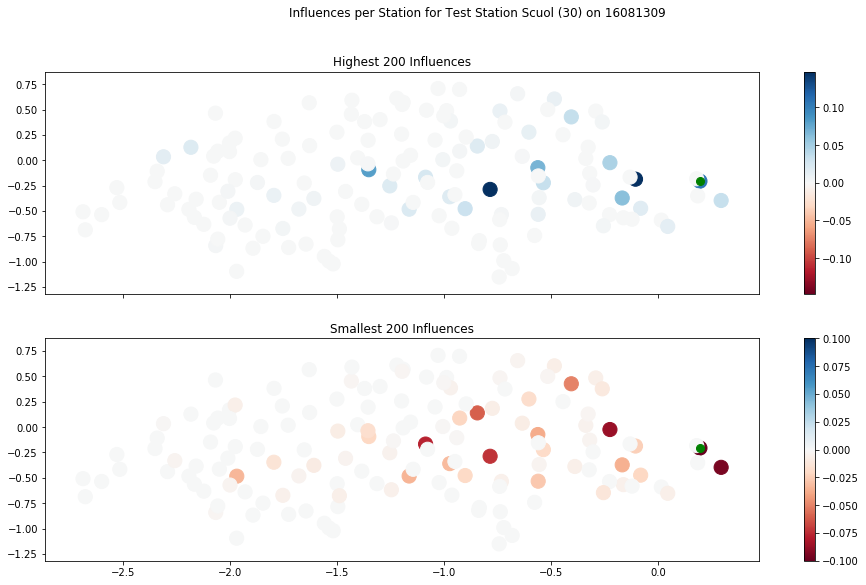

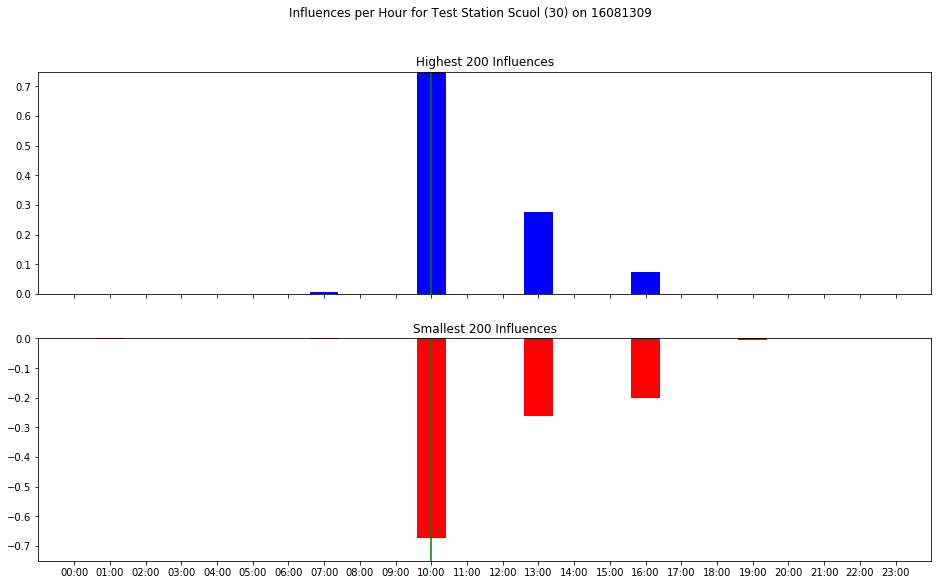

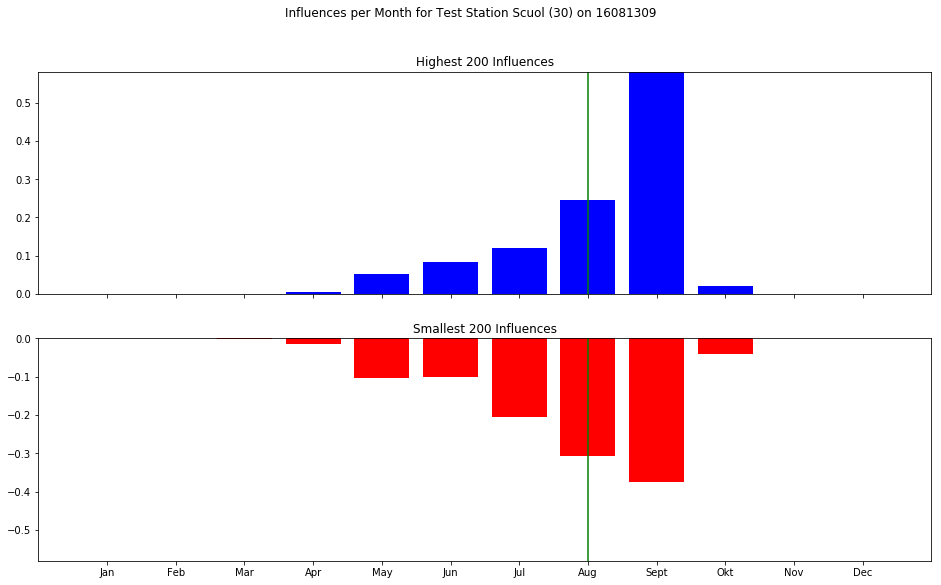

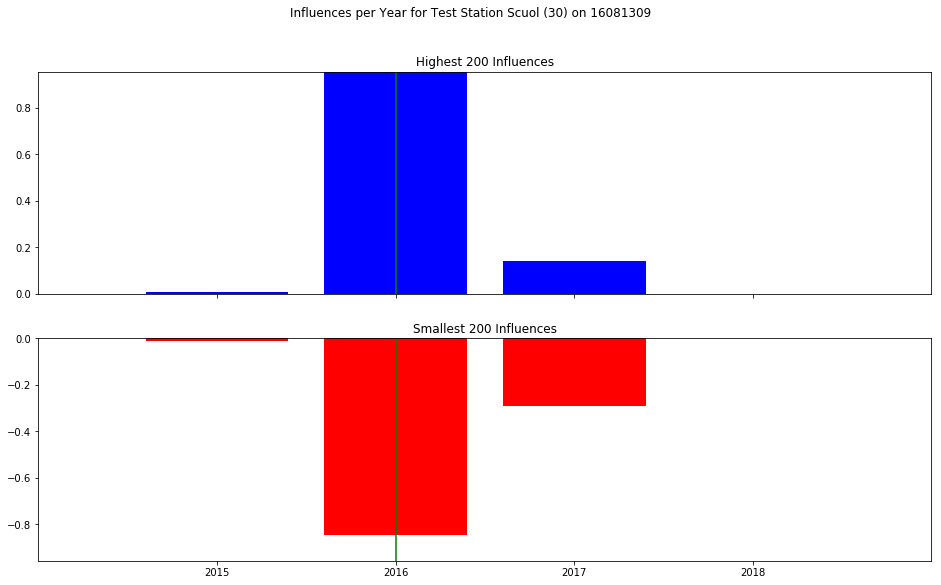

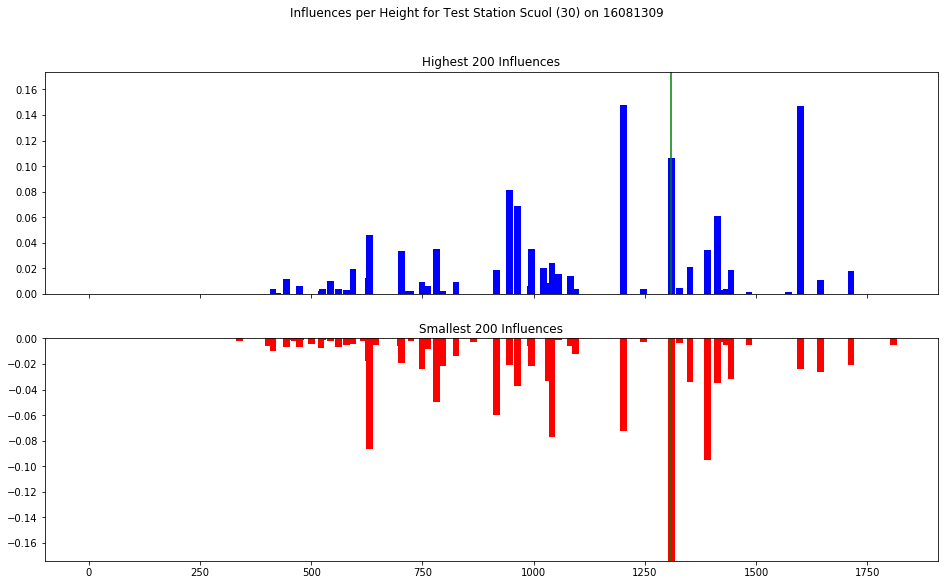

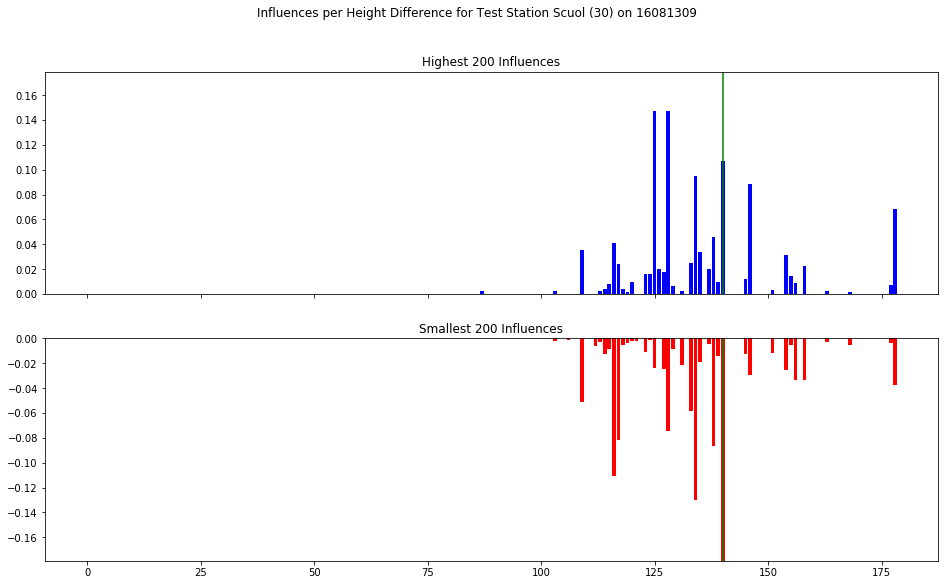

In [97]:
# adapt the labels to classes
min_label, max_label = np.minimum(np.min(Y_train_temp),np.min(Y_test_temp)), np.maximum(np.max(Y_train_temp),np.max(Y_test_temp))
n_classes = int(np.ceil((max_label - min_label)/2))
print(n_classes)

# the size of each bucket
size_of_bucket = (max_label - min_label)/n_classes

# we add two buckets that all sampels stay in the range on the left or right side, even if we shift the edges
bucket_edges = np.linspace(min_label-size_of_bucket,max_label+size_of_bucket,n_classes+3)

cetralize_function = lambda y: centralize_buckets_around_test_point(size_of_bucket, bucket_edges, False, y)

shapley_values_2_0 = run_knn([best_forecast_test_idx], Y_train_temp, Y_test_temp)
plotTestIdxResultsWithWeightedInfluences(best_forecast_test_idx, shapley_values_2_0)

#### Bin size 5

14
Calculation of knn values for test idx=98189 took 23.12551498413086


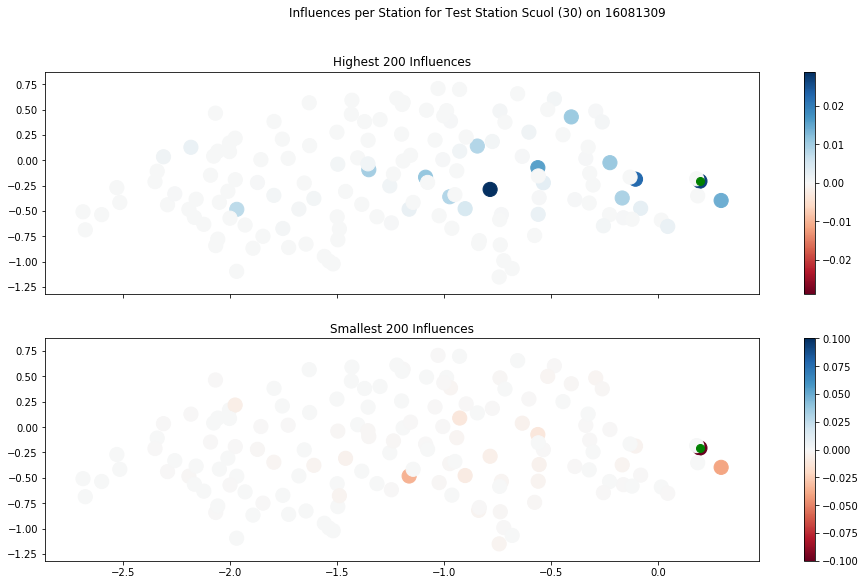

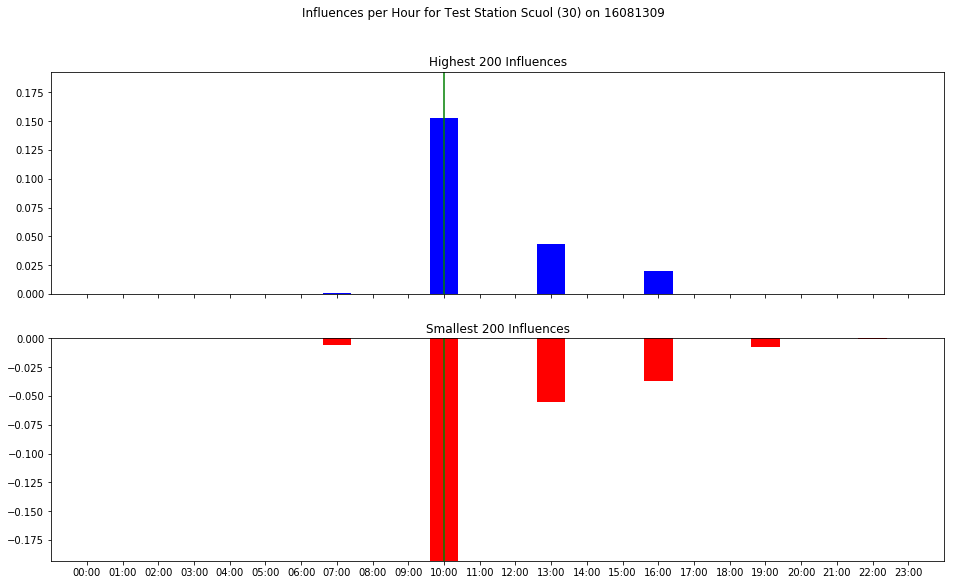

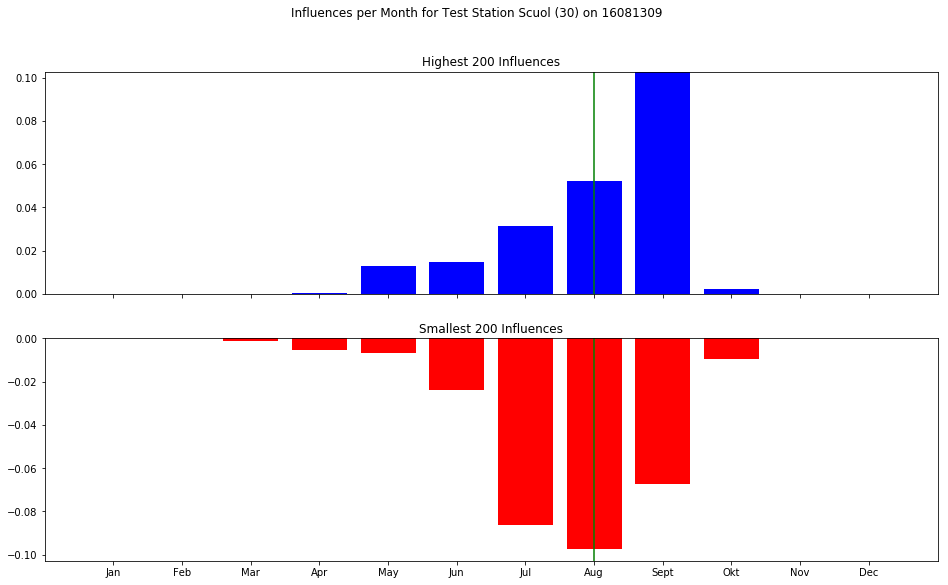

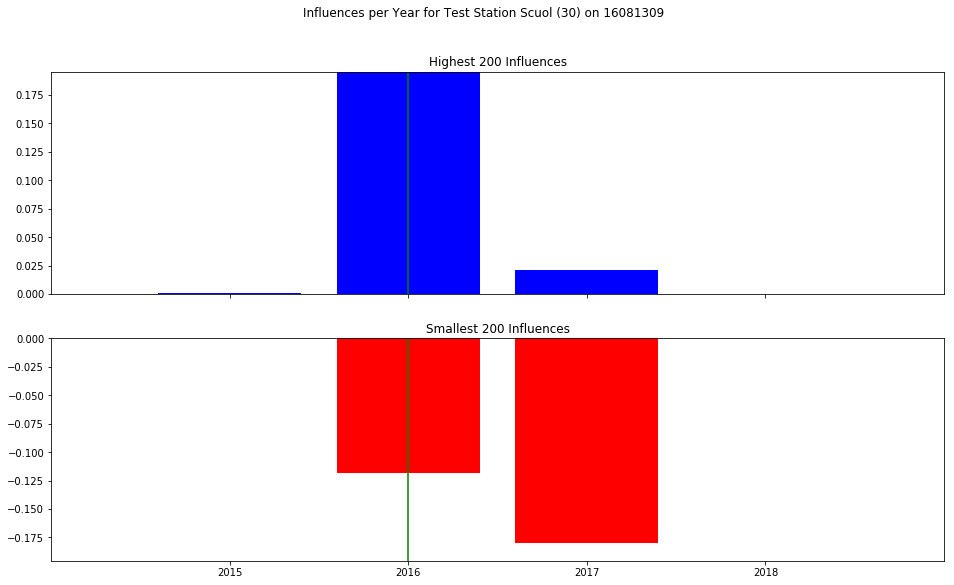

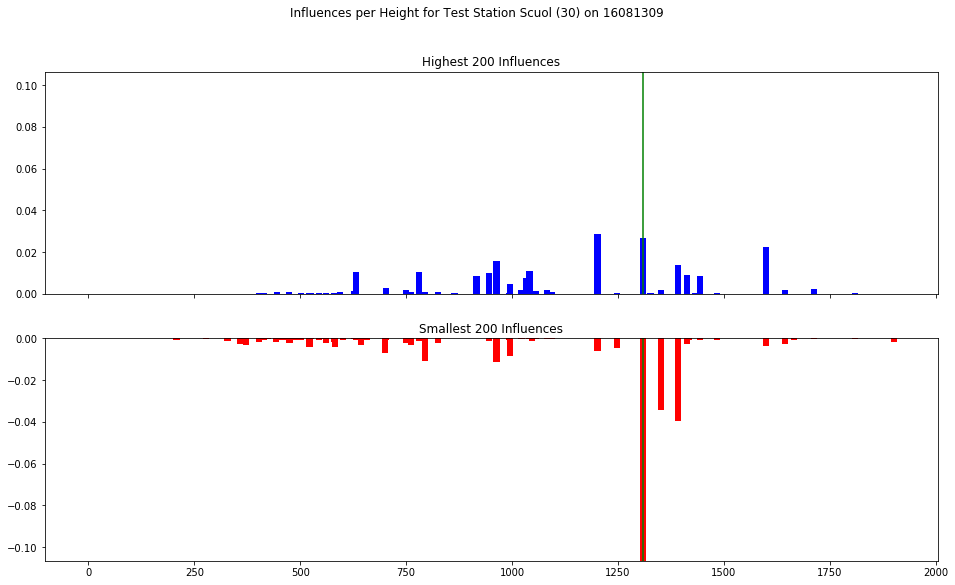

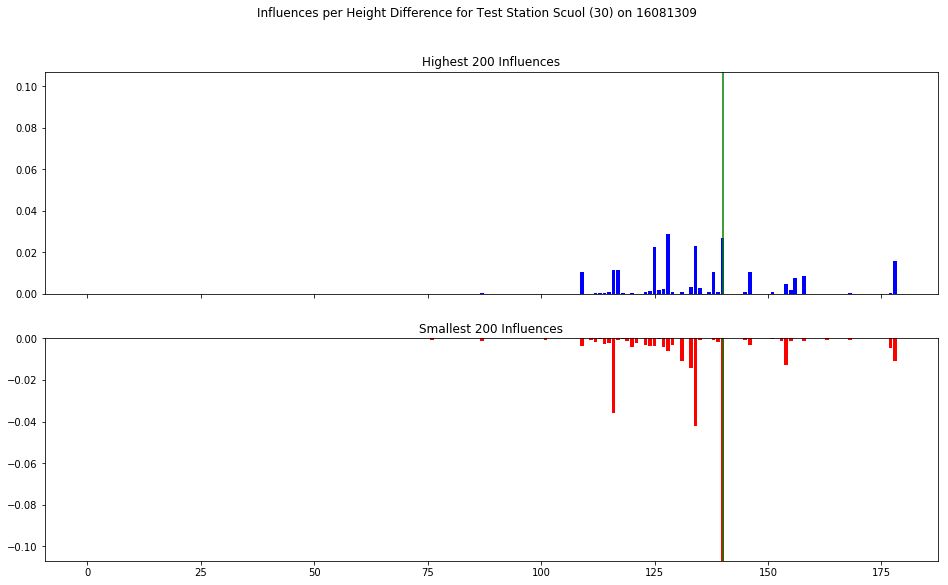

In [98]:
# adapt the labels to classes
min_label, max_label = np.minimum(np.min(Y_train_temp),np.min(Y_test_temp)), np.maximum(np.max(Y_train_temp),np.max(Y_test_temp))
n_classes = int(np.ceil((max_label - min_label)/5))
print(n_classes)

# the size of each bucket
size_of_bucket = (max_label - min_label)/n_classes

# we add two buckets that all sampels stay in the range on the left or right side, even if we shift the edges
bucket_edges = np.linspace(min_label-size_of_bucket,max_label+size_of_bucket,n_classes+3)

cetralize_function = lambda y: centralize_buckets_around_test_point(size_of_bucket, bucket_edges, False, y)

shapley_values_5_0 = run_knn([best_forecast_test_idx], Y_train_temp, Y_test_temp)
plotTestIdxResultsWithWeightedInfluences(best_forecast_test_idx, shapley_values_5_0)

In [ ]:
test_label_set

In [ ]:
for value in [shapley_values_0_1, shapley_values_0_3, shapley_values_0_5, shapley_values_1_0, shapley_values_2_0, shapley_values_5_0]:
    plt.plot(value)
    plt.show()

#### Order training points by similarity (2-norm) and plot the predicted class

In [ ]:
difference = X_train - X_test[best_forecast_test_idx]
norms = np.linalg.norm(np.float64(difference), axis=1)
sorted_norms = np.argsort(norms)
sorted_labels = Y_train[sorted_norms]
plt.plot(sorted_labels,marker='.', linestyle='None')
plt.hlines(Y_test[best_forecast_test_idx],0,len(sorted_labels), color='red')
plt.show()

#### Plotted the test labes and the corresponding bin ditribution

In [ ]:
ordered_test_labels = np.argsort(Y_test_temp)
Y_test_temp_shiftet = Y_test_temp[ordered_test_labels] + np.abs(np.min(Y_test_temp))
plt.figure(figsize=(16,9))
plt.plot(Y_test_temp_shiftet)
plt.plot(Y_test[ordered_test_labels])
plt.hlines(Y_test_temp_shiftet[best_forecast_test_idx],0,len(ordered_test_labels), color='red')
plt.show()

In [ ]:
#### Plotted fo each point the distance of the real prediction to the lower bin border

In [ ]:
plt.plot(Y_test_temp_shiftet - Y_test[ordered_test_labels])
plt.show()

In [ ]:
#### Distibution of test bins and train bins

In [ ]:
plt.hist(Y_train, bins=100)
plt.hist(Y_test, bins=100, color='red')
plt.show()

In [ ]:
month_dict={0:'Jan', 1:'Feb', 2:'Mar', 3:'Apr', 4:'May', 5:'Jun', 6:'Jul', 7:'Aug', 8:'Sept', 9:'Okt', 10:'Nov', 11:'Dec'}

station_idx_mapping = {}
for s_idx, s in enumerate(stations.data):
    station_idx_mapping[s] = s_idx
    
def plotTestIdxResultsWithInfluences(test_idx, influences):
    # get init, station, rlat, rlon, height and height difference for test idx
    test_init, test_station = test_data_set.iloc[test_idx].as_matrix()[0:2]
    test_station_rlat, test_station_rlon, test_station_height = station_positions.sel(station = test_station).data
    test_station_hh_diff = station_heigh_diff.sel(station = test_station).data
    # index in array representation of stations
    test_station_idx = stations.data.tolist().index(test_station)
    # get formatted station name
    test_station_name = station_names[test_station_idx].item()
    
    # define number of influences to be plotted
    k_largest_influences = 200
    k_smallest_influences = 200

    #hour_filterd_influence = filter_influence_by_hour(influences, train_data_set, test_init)
    #month_filtered_influence = filter_influence_by_month(influences, train_data_set, test_init)
    #init_filtered_influences = filter_influence_by_init(influences, train_data_set, test_init)

    # get largest and smallest influences
    largest_influence_idx = np.argsort(influences)[-k_largest_influences:]
    smallest_influence_idx = np.argsort(influences)[:k_smallest_influences]

    # get station & init samples with the largest influence
    station_init_by_largest_influence = []
    init_station_train_data = train_data_set.loc[:,'Init':'Station'].as_matrix()
    for train_sample_idx in largest_influence_idx:
        init, station = init_station_train_data[train_sample_idx]
        station_rlat, station_rlon, station_height = station_positions.isel(station = station_idx_mapping[station]).data
        station_hh_diff = station_heigh_diff.isel(station = station_idx_mapping[station]).data
        station_init_by_largest_influence += [(station, init, influences[train_sample_idx], station_rlat, station_rlon, station_height, station_hh_diff)]
    station_init_by_largest_influence = sorted(station_init_by_largest_influence, key=itemgetter(2))
    station_init_by_largest_influence_as_list = list(zip(*station_init_by_largest_influence))

    # get station & init samples with the smallest influence
    station_init_by_smallest_influence = []
    for train_sample_idx in smallest_influence_idx:
        init, station = init_station_train_data[train_sample_idx]
        station_rlat, station_rlon, station_height = station_positions.isel(station = station_idx_mapping[station]).data
        station_hh_diff = station_heigh_diff.isel(station = station_idx_mapping[station]).data.item()
        station_init_by_smallest_influence += [(station, init, influences[train_sample_idx], station_rlat, station_rlon, station_height, station_hh_diff)]
    station_init_by_smallest_influence = sorted(station_init_by_smallest_influence, key=itemgetter(2))
    station_init_by_smallest_influence_as_list = list(zip(*station_init_by_smallest_influence))

    # plot influence by station
    fig, axes = plt.subplots(2,1, sharex=True, sharey=True, figsize=(16,9))
    # plot stations with largest effect
    h, x_edges, y_edges, im = axes[0].hist2d(station_init_by_largest_influence_as_list[4],
                                             station_init_by_largest_influence_as_list[3],
                                             bins=10, range=np.array([(np.min(station_positions.data[:,1]),
                                                                      np.max(station_positions.data[:,1])),
                                                                      (np.min(station_positions.data[:,0]),
                                                                      np.max(station_positions.data[:,0]))]))
    axes[0].plot(test_station_rlon, test_station_rlat, marker='o', color='green', markersize=15)
    fig.colorbar(im, ax=axes[0])
    axes[0].set_title('Highest %s Influences' % k_largest_influences)

    # plot stations with smallest effect
    h, x_edges, y_edges, im = axes[1].hist2d(station_init_by_smallest_influence_as_list[4],
                                             station_init_by_smallest_influence_as_list[3],
                                             bins=10, range=np.array([(np.min(station_positions.data[:,1]),
                                                                      np.max(station_positions.data[:,1])),
                                                                      (np.min(station_positions.data[:,0]),
                                                                      np.max(station_positions.data[:,0]))]))
    axes[1].plot(test_station_rlon, test_station_rlat, marker='o', color='green', markersize=15)
    axes[1].set_ylim(np.min(station_positions.data[:,0]), np.max(station_positions.data[:,0]))
    axes[1].set_xlim(np.min(station_positions.data[:,1]), np.max(station_positions.data[:,1]))
    fig.colorbar(im, ax=axes[1])
    axes[1].set_title('Smallest %s Influences' % k_smallest_influences)
    plt.suptitle('Influences per Station for Test Station %s (%s) on %s' % (test_station_name,
                                                                         test_station, test_init))
    plt.show()
    plt.close()

    # plot influence by hour
    print("All hours: %s" % set([int(m[6:8]) for m in station_init_by_largest_influence_as_list[1]]))
    fig, axes = plt.subplots(2,1, sharex=True, figsize=(16,9))
    # plot stations with largest effect
    n, bins, patches = axes[0].hist([int(m[6:8]) for m in station_init_by_largest_influence_as_list[1]],
                                    bins=np.arange(25)-0.5)
    axes[0].axvline(x=int(test_init[6:8]), color='green')
    axes[0].set_title('Highest %s Influences' % k_largest_influences)
    
    # plot stations with largest effect
    axes[1].hist([int(m[6:8]) for m in station_init_by_smallest_influence_as_list[1]], bins=bins)
    axes[1].axvline(x=int(test_init[6:8]),color='green')
    axes[1].set_xlim(-1,24,1)
    axes[1].set_title('Smallest %s Influences' % k_smallest_influences)
    plt.suptitle('Influences per Hour for Test Station %s (%s) on %s' % (test_station_name,
                                                                         test_station, test_init))
    plt.setp(axes, xticks=range(24), xticklabels=["%02d:00" % h for h in range(24)])
    plt.show()
    plt.close()

    # plot influence by month
    print("All months: %s" % set([int(m[2:4]) for m in station_init_by_largest_influence_as_list[1]]))
    fig, axes = plt.subplots(2,1, sharex=True, figsize=(16,9))
    # plot stations with largest effect
    n, bins, patches = axes[0].hist([int(m[2:4]) for m in station_init_by_largest_influence_as_list[1]],
                                    bins=np.arange(14)-0.5)
    axes[0].axvline(x=int(test_init[2:4]),color='green')
    axes[0].set_title('Highest %s Influences' % k_largest_influences)

    # plot stations with smallest effect
    axes[1].hist([int(m[2:4]) for m in station_init_by_smallest_influence_as_list[1]], bins=bins)
    axes[1].axvline(x=int(test_init[2:4]),color='green')
    axes[0].set_xlim(0,14,1)
    axes[1].set_title('Smallest %s Influences' % k_smallest_influences)
    plt.suptitle('Influences per Month for Test Station %s (%s) on %s' % (test_station_name,
                                                                         test_station, test_init))
    #plt.setp(axes, xticks=range(1), xticklabels=[month_dict[m] for m in range(12)])
    plt.show()
    plt.close()

    # plot influence against height
    fig, axes = plt.subplots(2,1, sharex=True, figsize=(16,9))
    # plot stations with largest effect
    n, bins, patches = axes[0].hist(station_init_by_largest_influence_as_list[5], bins=100)
    axes[0].axvline(x=test_station_height,color='green')
    axes[0].set_title('Highest %s Influences' % k_largest_influences)
    
    # plot stations with smallest effect
    axes[1].hist(station_init_by_smallest_influence_as_list[5], bins=bins)
    axes[1].axvline(x=test_station_height,color='green')
    axes[1].set_title('Smallest %s Influences' % k_smallest_influences)
    
    plt.suptitle('Influences per Height for Test Station %s (%s) on %s' % (test_station_name,
                                                                         test_station, test_init))
    plt.show()
    plt.close()

    # plot influence against height difference
    fig, axes = plt.subplots(2,1, sharex=True, figsize=(16,9))
    # plot stations with largest effect
    n, bins, patches = axes[0].hist(station_init_by_largest_influence_as_list[6], bins=50)
    axes[0].axvline(x=test_station_hh_diff,color='green')
    axes[0].set_title('Highest %s Influences' % k_largest_influences)

    # plot stations with smallest effect
    axes[1].hist(station_init_by_smallest_influence_as_list[6], bins=bins)
    axes[1].axvline(x=test_station_hh_diff,color='green')
    axes[1].set_title('Smallest %s Influences' % k_smallest_influences)
    
    plt.suptitle('Influences per Height Difference for Test Station %s (%s) on %s' % (test_station_name,
                                                                         test_station, test_init))
    plt.show()
    plt.close()

In [ ]:
for key, value in actual_loss_diffs.items():
    plotTestIdxResultsWithWeightedInfluences(key, value)

In [ ]:
actual_loss_diffs.keys()

## Run a KNN-Regression

In [9]:
prediction_error.sel(data = 'difference')

<xarray.DataArray 'run_0' (init: 7055, station: 144)>
array([[ 5.397666,  0.1299  , -0.671551, ...,  0.670012,  0.457785,  1.882113],
       [ 5.931406,  0.546072,  0.270625, ...,  0.035626,  1.56253 ,  2.296078],
       [-0.513701, -0.289843,  0.138345, ...,  0.616054,  1.146203,  2.319295],
       ...,
       [ 0.970244, -0.179661,  0.549865, ..., -1.755389,  0.380414, -0.325752],
       [-3.173494, -0.487645, -0.912433, ..., -1.519075,  1.371859, -1.608418],
       [-0.780266, -1.517487, -0.875726, ..., -0.662136,  0.65589 , -2.700554]])
Coordinates:
  * init     (init) <U8 '15100103' '15100106' '15100109' '15100112' ...
  * station  (station) int32 2 3 4 6 7 8 9 10 11 13 14 15 17 18 19 20 22 23 ...
    data     <U10 'difference'
Attributes:
    init_type_mapping:  [('15100103', 'test'), ('15100106', 'test'), ('151001...

In [21]:
trained_knn_regressors = {}
for K in [25,30,35,40,45]:
    # take start time
    start = time()
    
    # define, fit and predict KNN-regressor
    knn = neighbors.KNeighborsRegressor(K, weights='distance', n_jobs=16).fit(X_train, Y_train_temp)
    
    # store trained KNN-Regressor
    trained_knn_regressors[K] = knn
    
    y_ = knn.predict(X_test)
    
    # calc. RMSE
    rmse = np.sqrt(np.mean(np.square(y_ - Y_test_temp)))
    
    # print results
    print("%sNN-Regression took %ss with an RMSE = %2.5f" % (K, str(time()-start), rmse))

25NN-Regression took 84.0446617603302s with an RMSE = 1.29272
30NN-Regression took 88.67303514480591s with an RMSE = 1.28970
35NN-Regression took 59.69937777519226s with an RMSE = 1.28727
40NN-Regression took 96.10076475143433s with an RMSE = 1.28609
45NN-Regression took 88.23351192474365s with an RMSE = 1.28501


### Results of KNN-Regression
1NN-Regression took 41.93775963783264s with an RMSE = 1.72212<br>
3NN-Regression took 49.68207025527954s with an RMSE = 1.43375<br>
5NN-Regression took 40.227123975753784s with an RMSE = 1.37092<br>
10NN-Regression took 51.34733963012695s with an RMSE = 1.32108<br>
20NN-Regression took 52.76699757575989s with an RMSE = 1.29733<br>
25NN-Regression took 84.0446617603302s with an RMSE = 1.29272<br>
30NN-Regression took 88.67303514480591s with an RMSE = 1.28970<br>
35NN-Regression took 59.69937777519226s with an RMSE = 1.28727<br>
40NN-Regression took 96.10076475143433s with an RMSE = 1.28609<br>
45NN-Regression took 88.23351192474365s with an RMSE = 1.28501<br>
50NN-Regression took 66.15110540390015s with an RMSE = 1.28431<br>
100NN-Regression took 77.81166553497314s with an RMSE = 1.28147<br>
200NN-Regression took 86.16524505615234s with an RMSE = 1.28154<br>
500NN-Regression took 109.13341331481934s with an RMSE = 1.28332<br>
1000NN-Regression took 141.19124364852905s with an RMSE = 1.28571